# Sentiment Analysis

In this notebook, we will investigate the sentiment visible in politicians' tweets. We will perform two methods: a lexicon-based approach using VADER [1] and a supervised approach using the most recent version of the RoBERTa-base model [2].

## 1. Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import tqdm
import torch

from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from wordcloud import WordCloud

## 2. Reading data

In [61]:
df = pd.read_parquet('../data/03.cleaned/df_combined.parquet')
nltk.download('vader_lexicon')
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,in_reply_to_user_id,reply_settings,author_id,context_annotations,id,text,edit_controls,referenced_tweets,created_at,edit_history_tweet_ids,...,reply_count,like_count,quote_count,impression_count,text_clean_en,text_clean_en_demojized,text_clean_demojized,emoji_count_en,emoji_count,name
0,375146901.0,everyone,1.182212e+09,"[{'domain': {'description': 'Named people in the world like Nelson Mandela', 'id': '10', 'name': 'Person'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'Politicians in the world, like Joe Biden', 'id': '35', 'name': 'Politician'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politics', 'id': '847878884917886977', 'name': 'Politics'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politician', 'id': '1070032753834438656', 'name': 'Political figures'}}]",1846277256509116672,"@donaldtusk Niezrealizowanie większości ze ""100 konkretów"", zamiast transparentności ""sklep meblarski"" przy obsadzaniu SSP, zamiast taniego państwa rekordowy deficyt i najliczniejszy rząd w historii, a zamiast praworządności państwo policyjne. Oto obraz Waszych rządów rok po wyborach.","{'editable_until': '2024-10-15 20:49:34+00:00', 'edits_remaining': 5, 'is_edit_eligible': False}","[{'id': '1846091776269963695', 'type': 'replied_to'}]",2024-10-15 19:49:34+00:00,[1846277256509116623],...,1,33,0,1555,"Failure to implement most of the ""100 specifics"", instead of transparency a ""furniture store"" when appointing the Social Security Service, instead of a cheap state, a record deficit and the most numerous government in history, and instead of the rule of law, a police state. This is a picture of your government a year after the elections.","Failure to implement most of the ""100 specifics"", instead of transparency a ""furniture store"" when appointing the Social Security Service, instead of a cheap state, a record deficit and the most numerous government in history, and instead of the rule of law, a police state. This is a picture of your government a year after the elections.","Niezrealizowanie większości ze ""100 konkretów"", zamiast transparentności ""sklep meblarski"" przy obsadzaniu SSP, zamiast taniego państwa rekordowy deficyt i najliczniejszy rząd w historii, a zamiast praworządności państwo policyjne. Oto obraz Waszych rządów rok po wyborach.",0,0,Bartłomiej Pejo
1,NaN,everyone,1.182212e+09,"[{'domain': {'description': 'Named people in the world like Nelson Mandela', 'id': '10', 'name': 'Person'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'Politicians in the world, like Joe Biden', 'id': '35', 'name': 'Politician'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politics', 'id': '847878884917886977', 'name': 'Politics'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politician', 'id': '1070032753834438656', 'name': 'Political figures'}}]",1846222583898784000,Rok po wyborach trzeba powiedzieć jedno - nie na takie państwo Donal

## 3. Lexicon based Sentiment Analysis (VADER)

In [62]:
sia = SentimentIntensityAnalyzer()
res = {}

for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    text = row['text_clean_en_demojized']
    myID = row['id']
    res[myID] = sia.polarity_scores(text)

vader_res = pd.DataFrame.from_dict(res, orient='index').reset_index()
vader_res.rename(columns={'index': 'id', 'neg': 'neg_vader', 'neu': 'neu_vader', 'pos': 'pos_vader', 'compound': 'compound_vader'}, inplace=True)
print("Average sentiment scores:")
print(vader_res.iloc[:, 1:5].mean())
df_no_na = df.merge(vader_res, on='id', how='left')
df_no_na[["username", "name", "text_clean_en", "neg_vader", "neu_vader", "pos_vader", "compound_vader"]].head()

100%|██████████| 48331/48331 [00:16<00:00, 2970.76it/s]

Average sentiment scores:
neg_vader         0.064897
neu_vader         0.783345
pos_vader         0.151343
compound_vader    0.164220
dtype: float64


,username,name,text_clean_en,neg_vader,neu_vader,pos_vader,compound_vader
0,bartlomiejpejo,Bartłomiej Pejo,"Failure to implement most of the ""100 specifics"", instead of transparency a ""furniture store"" when appointing the Social Security Service, instead of a cheap state, a record deficit and the most numerous government in history, and instead of the rule of law, a police state. This is a picture of your government a year after the elections.",0.106,0.851,0.043,-0.5574
1,bartlomiejpejo,Bartłomiej Pejo,"A year after the elections, one thing must be said - this is not the country Donald Tusk agreed with voters!",0.000,0.883,0.117,0.3382
2,bartlomiejpejo,Bartłomiej Pejo,"❌ We are a year after the elections, and Poland is sinking into crisis and anarchy. Of the promised 100 specific items, Donald Tusk's government implemented only about 30. For example, such demands as: an increase in the tax-free amount, the introduction of a system of medical visits via SMS and...",0.075,0.838,0.087,-0.0772
3,bartlomiejpejo,Bartłomiej Pejo,"A year has passed since the parliamentary elections. Many promises were made by the government during the election campaign. What do we get from it today? In smiling Poland we have chaos in the justice system, financial gridlock in the health service and a record deficit. Donald Tusk's rule is a disaster for...",0.165,0.693,0.142,-0.3612
4,bartlomiejpejo,Bartłomiej Pejo,#I'm going11 🇵 🇱,0.000,1.000,0.000,0.0000


In [63]:
df_for_bert = df_no_na.copy()

### 3.1. Top 5 most negative politicians

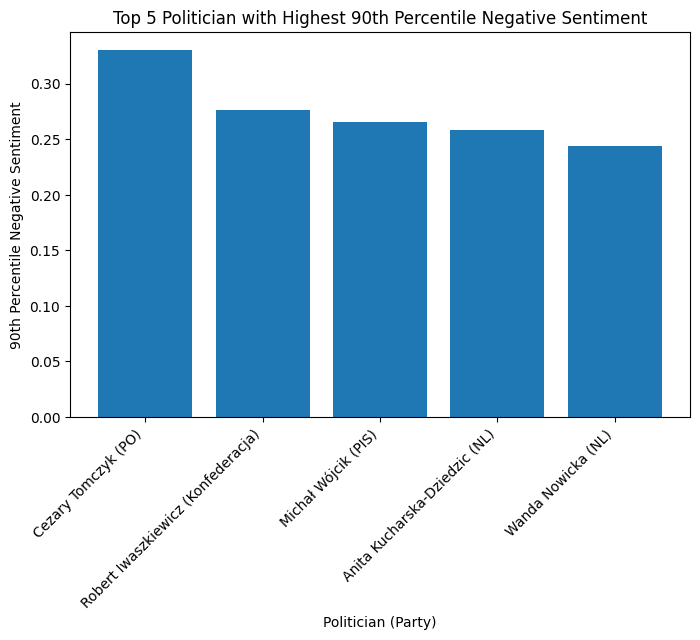

In [64]:
percentile_90_neg = df_no_na.groupby('username')['neg_vader'].quantile(0.90).reset_index()

top5_neg_sentiment = percentile_90_neg.sort_values(by='neg_vader', ascending=False).head(5)
top5_neg_sentiment = top5_neg_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_neg_sentiment['name_with_party'] = top5_neg_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_neg_sentiment['name_with_party'], top5_neg_sentiment["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Negative Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Negative Sentiment')
plt.show()

According to the VADER analysis, the top 5 politicians with the highest 90th percentile of negative sentiment in their tweets represent almost all parties except PL2050, with two individuals from Nowa Lewica included.

### 3.2. Top 5 most positive politicians

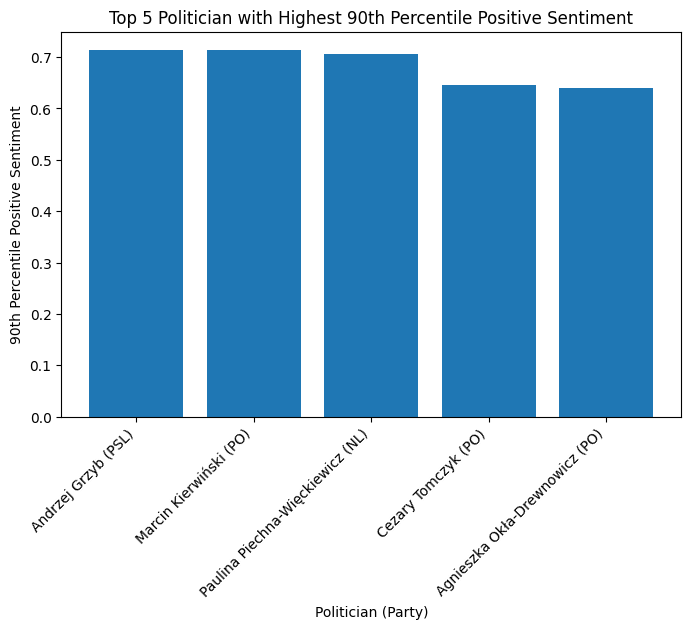

In [65]:
percentile_90_pos = df_no_na.groupby('username')['pos_vader'].quantile(0.90).reset_index()

top5_pos_sentiment = percentile_90_pos.sort_values(by='pos_vader', ascending=False).head(5)
top5_pos_sentiment = top5_pos_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_pos_sentiment['name_with_party'] = top5_pos_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_pos_sentiment['name_with_party'], top5_pos_sentiment["pos_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Positive Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Positive Sentiment')
plt.show()

According to the VADER analysis, the top 5 politicians with the highest 90th percentile of positive sentiment in their tweets include 3 individuals from PO, 1 from PSL, and 1 from NL.

### 3.3. Negative Sentiment on party level

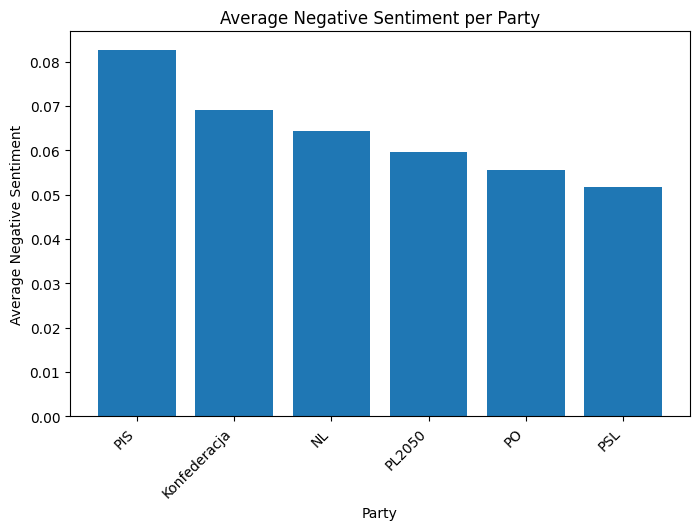

In [66]:
average_neg_sentiment_party = df_no_na.groupby('party')['neg_vader'].mean().reset_index()

top5_avg_neg_sentiment_party = average_neg_sentiment_party.sort_values(by='neg_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_neg_sentiment_party['party'], top5_avg_neg_sentiment_party["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Average Negative Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Negative Sentiment')
plt.show()


We can observe that the plot shows the highest average negative sentiment for PIS, followed closely by Konfederacja. The lowest average negative sentiment is observed for PO and PSL.

### 3.4. Positive Sentiment on party level

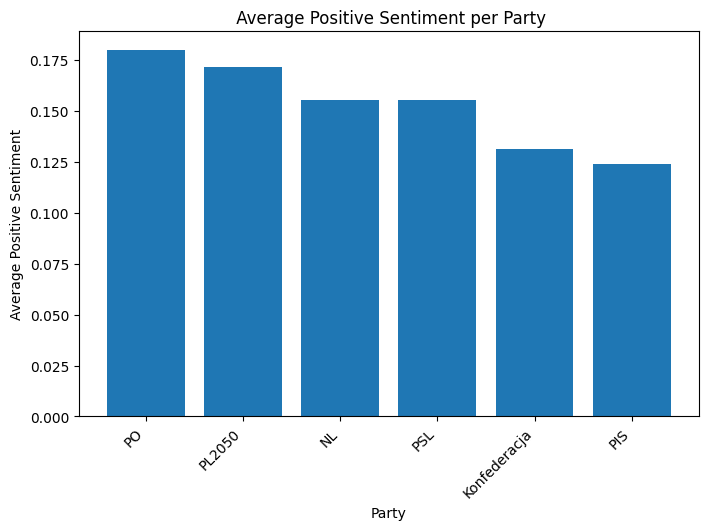

In [67]:
average_pos_sentiment_party = df_no_na.groupby('party')['pos_vader'].mean().reset_index()

top5_avg_pos_sentiment_party = average_pos_sentiment_party.sort_values(by='pos_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_pos_sentiment_party['party'], top5_avg_pos_sentiment_party["pos_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(' Average Positive Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Positive Sentiment')
plt.show()


We can observe that the plot is a rotated version of the previous plot. The highest average positive sentiment is for PO, PL2050, NL, and PSL, while Konfederacja, and PIS have lower scores.

### 3.5. Most Negative Tweets 

In [68]:
top_5_negative_tweets = df_no_na.nlargest(10, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
print("Top 5 Most Negative Tweets:")
print(top_5_negative_tweets)

Top 5 Most Negative Tweets:
                    name         party text_clean_en  neg_vader
2220    Konrad Berkowicz  Konfederacja    Criminals.        1.0
4317        Michał Wawer  Konfederacja            NO        1.0
4487        Michał Wawer  Konfederacja            NO        1.0
5087    Grzegorz Płaczek  Konfederacja     Disgrace!        1.0
5214    Grzegorz Płaczek  Konfederacja          - NO        1.0
7150   Witold Tumanowicz  Konfederacja           NO.        1.0
7155   Witold Tumanowicz  Konfederacja           NO.        1.0
9179    Marek Sypniewski  Konfederacja            NO        1.0
10551   Sławomir Mentzen  Konfederacja           NO.        1.0
10851    Krzysztof Tuduj  Konfederacja          Sad.        1.0


In [69]:
pd.set_option('display.max_colwidth', None)
df_no_na['word_count'] = df_no_na['text_clean_en'].apply(lambda x: len(str(x).split()))
df_no_na = df_no_na[df_no_na['word_count'] >= 3]
top_negative_posts = df_no_na.nlargest(10, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
print("Top 5 Most Negative Tweets (longer than 2 words):")
print(top_negative_posts)

Top 5 Most Negative Tweets (longer than 2 words):
                             name         party                 text_clean_en  \
43414                  Paweł Śliz        PL2050      Terribly weak. Terrible.   
13707              Marcin Kulasek            NL             No more war!  🇵 🇱   
31305            Dorota Niedziela            PO    Shamelessness and villainy   
41882       Paulina Hennig-Kloska        PL2050         Sad and embarrassing.   
1841             Konrad Berkowicz  Konfederacja          PiS, PO - one evil!    
11148          Włodzimierz Skalik  Konfederacja          PiS, PO - one evil.    
40452                  Paweł Śliz        PL2050          Sarcasm was sarcasm.   
18069               Wanda Nowicka            NL              What a bastard!    
22640  Małgorzata Moskwa-Wodnicka            NL                 Quite a bomb!   
35714            Dorota Niedziela            PO  Liars, liars, liars... #PIS    

       neg_vader  
43414      1.000  
13707      0.870  
3

We can observe that VADER was able to capture negative tweets. However, they were not as negative as expected. Without filtering the shortest tweets, the most negative tweets were simply "NO." After filtering to consider tweets longer than two words, the tweets were still not very negative or offensive.

### 3.6. Most Positive Tweets 

In [70]:
top_5_positive_tweets = df_no_na.nlargest(10, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
print("Top 5 Most Positive Tweets:")
print(top_5_positive_tweets)

Top 5 Most Positive Tweets:
                              name         party                text_clean_en  \
3892              Marek Sypniewski  Konfederacja                  Good luck !   
5922              Sławomir Mentzen  Konfederacja  Congratulations! Good luck!   
13553            Krzysztof Śmiszek            NL       Great! Welcome aboard!   
19908            Beata Maciejewska            NL                  I invite :)   
20817            Krzysztof Śmiszek            NL   Welcome aboard! Good luck!   
21189            Krzysztof Śmiszek            NL         Well, cool, cool :-)   
22747   Małgorzata Moskwa-Wodnicka            NL         Happy!!! 🇵 🇱 🇵 🇱 🇵 🇱   
22951  Paulina Piechna-Więckiewicz            NL                   I invite !   
41580                 Maciej Żywno        PL2050                good, good :)   
44423                 Maciej Żywno        PL2050              I invite :)       

       pos_vader  
3892         1.0  
5922         1.0  
13553        1.0  
1990

In [71]:
pd.set_option('display.max_colwidth', None)
df_no_na = df_no_na[df_no_na['word_count'] >= 10]
top_positive_posts = df_no_na.nlargest(10, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
print("Top 5 Most Positive Tweets (longer than 9 words):")
print(top_positive_posts)

Top 5 Most Positive Tweets (longer than 9 words):
                            name         party  \
31354           Dorota Niedziela            PO   
48269           Stefan Krajewski           PSL   
18357      Włodzimierz Czarzasty            NL   
5535            Sławomir Mentzen  Konfederacja   
3484            Marek Sypniewski  Konfederacja   
31271           Dorota Niedziela            PO   
37692  Małgorzata Kidawa-Błońska            PO   
272              Bartłomiej Pejo  Konfederacja   
19195   Anita Kucharska-Dziedzic            NL   
41496               Maciej Żywno        PL2050   

                                                                                                           text_clean_en  \
31354                                                         Celebrating 🇵 🇱 🇵 🇱 🇵 🇱 🇵 🇱 #DzieńaflagiRP 🇵 🇱 🇵 🇱 🇵 🇱 🇵 🇱   
48269                                                                    Dear Ladies, please accept my best wishes 🌹 🌹 🌹   
18357             #EuropeFo

VADER effectively captured positive tweets. Unlike negative tweets, unfiltered positive tweets are meaningful and often congratulatory. Tweets longer than 9 words are also related to celebrations, congratulations, and positive events.

### 3.7. Wordclouds

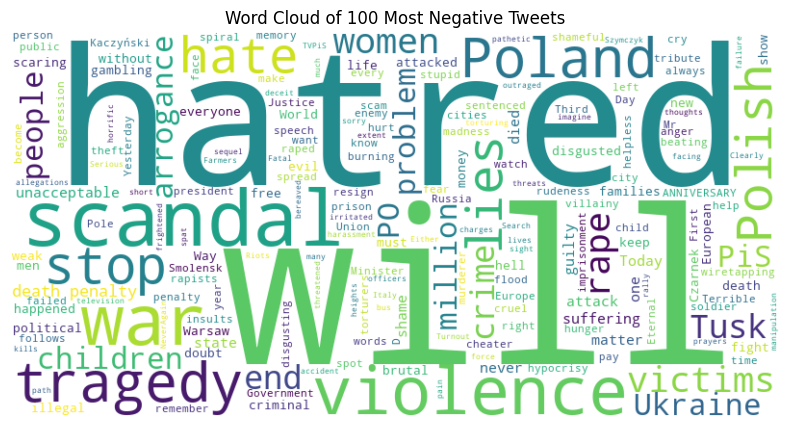

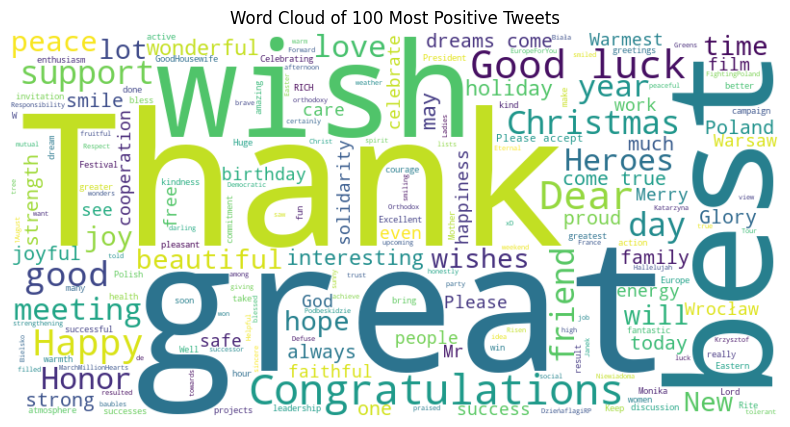

In [72]:
top_negative_posts = df_no_na.nlargest(100, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
negative_texts = ' '.join(top_negative_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Negative Tweets')
plt.show()

top_positive_posts = df_no_na.nlargest(100, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
negative_texts = ' '.join(top_positive_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Positive Tweets')
plt.show()

## 4. Supervised approach Sentiment Analysis (BERT)

In [73]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL, use_safetensors=True)

def bert_predict(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output[0][0].cpu().numpy()
    scores = softmax(scores)
    return scores

df_for_bert['text_bert'] = df_for_bert['text_clean_en_demojized'].apply(preprocess)
df_for_bert[['negative_bert', 'neutral_bert', 'positive_bert']] = df_for_bert['text_bert'].apply(lambda x: pd.Series(bert_predict(x), index=['negative', 'neutral', 'positive']))
df_for_bert[["username", "name", "text_clean_en", "negative_bert", "neutral_bert", "positive_bert"]].head()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,username,name,text_clean_en,negative_bert,neutral_bert,positive_bert
0,bartlomiejpejo,Bartłomiej Pejo,"Failure to implement most of the ""100 specifics"", instead of transparency a ""furniture store"" when appointing the Social Security Service, instead of a cheap state, a record deficit and the most numerous government in history, and instead of the rule of law, a police state. This is a picture of your government a year after the elections.",0.850091,0.139991,0.009918
1,bartlomiejpejo,Bartłomiej Pejo,"A year after the elections, one thing must be said - this is not the country Donald Tusk agreed with voters!",0.755525,0.230793,0.013682
2,bartlomiejpejo,Bartłomiej Pejo,"❌ We are a year after the elections, and Poland is sinking into crisis and anarchy. Of the promised 100 specific items, Donald Tusk's government implemented only about 30. For example, such demands as: an increase in the tax-free amount, the introduction of a system of medical visits via SMS and...",0.786622,0.204867,0.008511
3,bartlomiejpejo,Bartłomiej Pejo,"A year has passed since the parliamentary elections. Many promises were made by the government during the election campaign. What do we get from it today? In smiling Poland we have chaos in the justice system, financial gridlock in the health service and a record deficit. Donald Tusk's rule is a disaster for...",0.817513,0.169303,0.013184
4,bartlomiejpejo,Bartłomiej Pejo,#I'm going11 🇵 🇱,0.044821,0.769139,0.186040


In [74]:
df_for_bert

,in_reply_to_user_id,reply_settings,author_id,context_annotations,id,text,edit_controls,referenced_tweets,created_at,edit_history_tweet_ids,...,emoji_count,name,neg_vader,neu_vader,pos_vader,compound_vader,text_bert,negative_bert,neutral_bert,positive_bert
0,375146901.0,everyone,1.182212e+09,"[{'domain': {'description': 'Named people in the world like Nelson Mandela', 'id': '10', 'name': 'Person'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'Politicians in the world, like Joe Biden', 'id': '35', 'name': 'Politician'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politics', 'id': '847878884917886977', 'name': 'Politics'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politician', 'id': '1070032753834438656', 'name': 'Political figures'}}]",1846277256509116672,"@donaldtusk Niezrealizowanie większości ze ""100 konkretów"", zamiast transparentności ""sklep meblarski"" przy obsadzaniu SSP, zamiast taniego państwa rekordowy deficyt i najliczniejszy rząd w historii, a zamiast praworządności państwo policyjne. Oto obraz Waszych rządów rok po wyborach.","{'editable_until': '2024-10-15 20:49:34+00:00', 'edits_remaining': 5, 'is_edit_eligible': False}","[{'id': '1846091776269963695', 'type': 'replied_to'}]",2024-10-15 19:49:34+00:00,[1846277256509116623],...,0,Bartłomiej Pejo,0.106,0.851,0.043,-0.5574,"Failure to implement most of the ""100 specifics"", instead of transparency a ""furniture store"" when appointing the Social Security Service, instead of a cheap state, a record deficit and the most numerous government in history, and instead of the rule of law, a police state. This is a picture of your government a year after the elections.",0.850091,0.139991,0.009918
1,NaN,everyone,1.182212e+09,"[{'domain': {'description': 'Named people in the world like Nelson Mandela', 'id': '10', 'name': 'Person'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'Politicians in the world, like Joe Biden', 'id': '35', 'name': 'Politician'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politics', 'id': '847878884917886977', 'name': 'Politics'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politician', 'id': '1070032753834438656', 'name': 'Political figures'}}]",1846222583898784000,Rok po wyborach trzeba powiedzieć jedno - nie na takie państwo Donald Tusk umawiał się z wyborcami! https://t.co/4Jh5Ni6sgr,"{'editable_until': '2024-10-15 17:12:19+00:00', 'edits_remaining': 5, 'is_edit_eligible': True}",None,2024-10-15 16:12:19+00:00,[1846222583898784025],...,0,Bartłomiej Pejo,0.000,0.883,0.117,0.3382,"A year after the elections, one thing must be said - this is not the country Donald Tusk agreed with voters!",0.755525,0.230793,0.013682
2,NaN,everyone,1.182212e+09,None,1846161400328028160,"❌ Mamy rok po wyborach, a Polska pogrąża się w kryzysie i anarchii. \n\nZ obiecanych 100 konkretów rząd Donalda Tuska zrealizował tylko około 30. Nie zostały zrealizowane 

In [75]:
df_for_bert.to_parquet('../data/03.cleaned/df_bert_values_GIT.parquet', index=False)

### 4.1. Top 5 most negative politicians

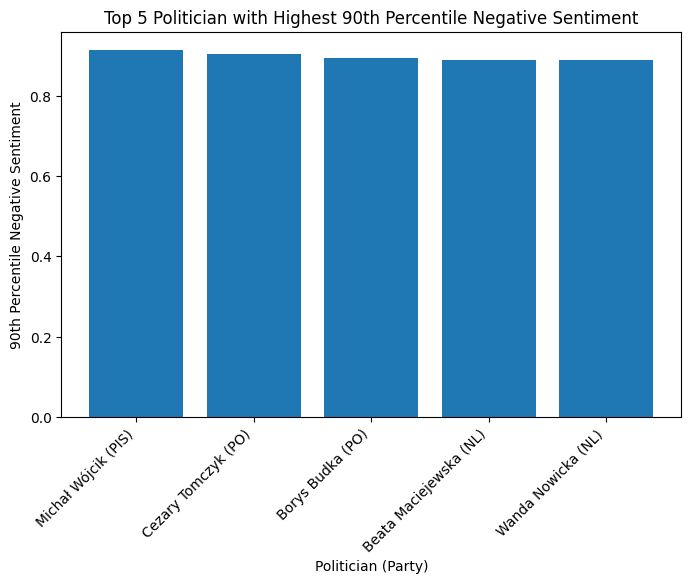

In [76]:
percentile_90_neg = df_for_bert.groupby('username')['negative_bert'].quantile(0.90).reset_index()

top5_neg_sentiment = percentile_90_neg.sort_values(by='negative_bert', ascending=False).head(5)
top5_neg_sentiment = top5_neg_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_neg_sentiment['name_with_party'] = top5_neg_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_neg_sentiment['name_with_party'], top5_neg_sentiment["negative_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Negative Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Negative Sentiment')
plt.show()

We can observe that the 90th percentile Negative Sentiment scores are quite comparable among the top 5 politicians. In comparison to VADER three politicians remain the same, while two have changed. This indicates a difference in predictions made by the VADER and BERT models.

### 4.2. Top 5 most positive politicians

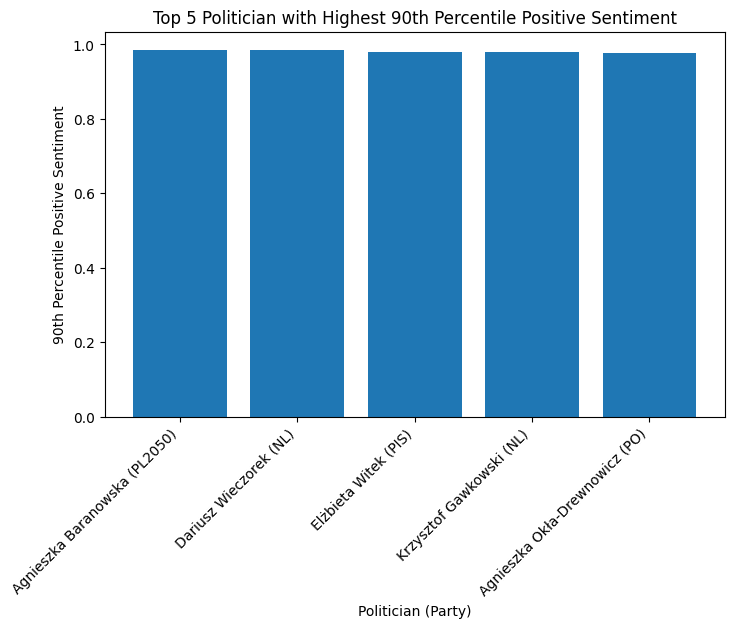

In [77]:
percentile_90_pos = df_for_bert.groupby('username')['positive_bert'].quantile(0.90).reset_index()

top5_pos_sentiment = percentile_90_pos.sort_values(by='positive_bert', ascending=False).head(5)
top5_pos_sentiment = top5_pos_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_pos_sentiment['name_with_party'] = top5_pos_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_pos_sentiment['name_with_party'], top5_pos_sentiment["positive_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Positive Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Positive Sentiment')
plt.show()

We can observe that the 90th percentile Positive Sentiment scores are quite comparable among the top 5 politicians. Compared to the VADER method, there are significant changes; only one politician stays the same.

### 4.3. Negative Sentiment on party level

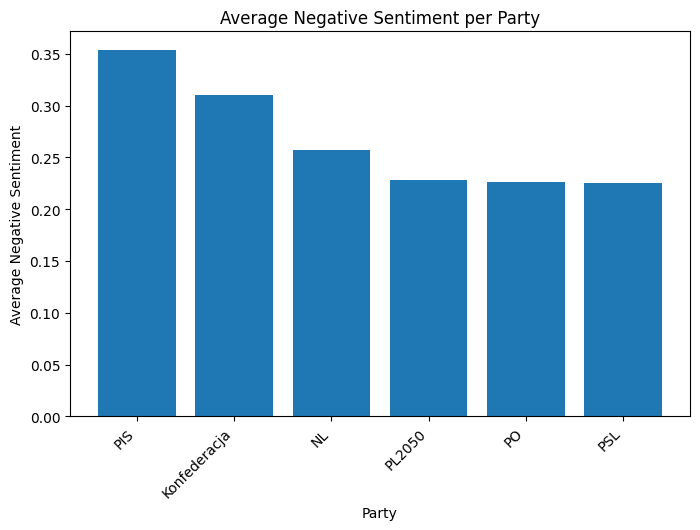

In [78]:
average_neg_sentiment_party = df_for_bert.groupby('party')['negative_bert'].mean().reset_index()

top5_avg_neg_sentiment_party = average_neg_sentiment_party.sort_values(by='negative_bert', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_neg_sentiment_party['party'], top5_avg_neg_sentiment_party["negative_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Average Negative Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Negative Sentiment')
plt.show()


We can observe that the party ranking is the same to this one obtained using the VADER method.

### 4.4. Positive Sentiment on party level

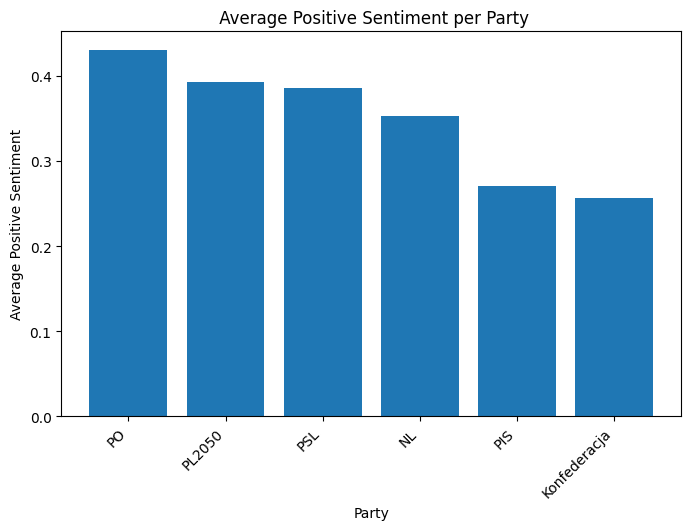

In [79]:
average_pos_sentiment_party = df_for_bert.groupby('party')['positive_bert'].mean().reset_index()

top5_avg_pos_sentiment_party = average_pos_sentiment_party.sort_values(by='positive_bert', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_pos_sentiment_party['party'], top5_avg_pos_sentiment_party["positive_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(' Average Positive Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Positive Sentiment')
plt.show()


In comparison to VADER, the first two positions remain unchanged, while the parties ranked third and fourth, as well as fifth and sixth, switch places.

### 4.5. Most Negative Tweets 

In [80]:
top_5_negative_tweets = df_for_bert.nlargest(10, 'negative_bert')[['name', 'party', 'text_clean_en', 'negative_bert']]
print("Top 5 Most Negative Tweets:")
print(top_5_negative_tweets)

Top 5 Most Negative Tweets:
                            name         party  \
26279              Michał Wójcik           PIS   
16941               Tomasz Trela            NL   
33342          Marcin Kierwiński            PO   
18891   Anita Kucharska-Dziedzic            NL   
16087               Tomasz Trela            NL   
23249             Robert Biedroń            NL   
47005  Władysław Kosiniak-Kamysz           PSL   
5399            Sławomir Mentzen  Konfederacja   
35512           Dorota Niedziela            PO   
4002            Marek Sypniewski  Konfederacja   

                                                                                                                                                                                                                                                                                                                                             text_clean_en  \
26279                                                                  

The RoBERTa model is able to identify more sophisticated negative tweets. Unlike VADER, which often predicts that the most negative tweets are single negative words, RoBERTa captures the nuanced meaning of the tweets. There is no need to filter out short tweets with only one word (e.g., "NO") as was necessary with VADER. These tweets are mostly critical of the actions of other parties, with the majority coming from NL but also from PO, Konfederacja, PiS and PSL.

### 4.6. Most Positive Tweets 

In [81]:
top_5_positive_tweets = df_for_bert.nlargest(10, 'positive_bert')[['name', 'party', 'text_clean_en', 'positive_bert']]
print("Top 5 Most Positive Tweets:")
print(top_5_positive_tweets)

Top 5 Most Positive Tweets:
                            name   party  \
13016          Krzysztof Śmiszek      NL   
31561                 Ewa Kopacz      PO   
45588  Władysław Kosiniak-Kamysz     PSL   
30767             Cezary Tomczyk      PO   
37692  Małgorzata Kidawa-Błońska      PO   
16543               Tomasz Trela      NL   
40714                 Paweł Śliz  PL2050   
46042           Piotr Zgorzelski     PSL   
38555  Agnieszka Okła-Drewnowicz      PO   
39098          Rafał Trzaskowski      PO   

                                                                                                                                                                                                                                                                                          text_clean_en  \
13016                                                                                                                                                                                       

The most positive tweets from the RoBERTa model are more meaningful than those from the VADER method. They are notably longer and often reflect the authors' happiness following certain events, such as meetings with voters or positive election results.

### 4.7. Word clouds

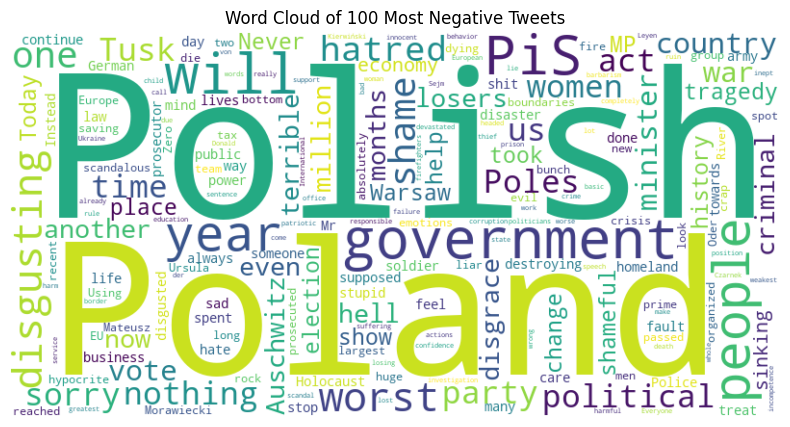

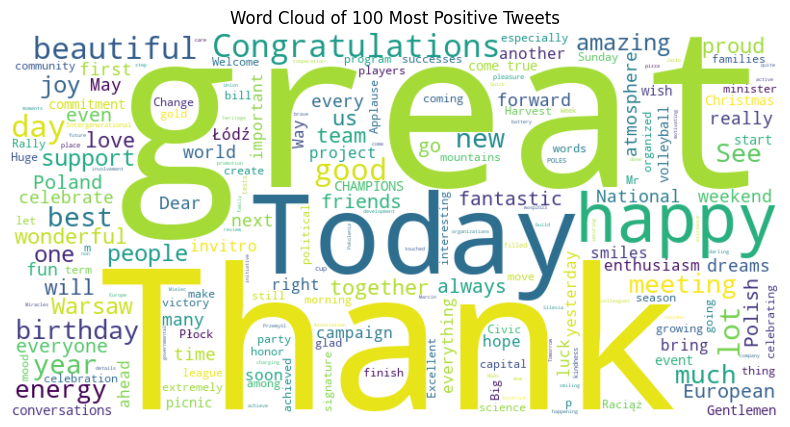

In [82]:
top_negative_posts = df_for_bert.nlargest(100, 'negative_bert')[['name', 'party', 'text_clean_en', 'negative_bert']]
negative_texts = ' '.join(top_negative_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Negative Tweets')
plt.show()

top_positive_posts = df_for_bert.nlargest(100, 'positive_bert')[['name', 'party', 'text_clean_en', 'positive_bert']]
negative_texts = ' '.join(top_positive_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Positive Tweets')
plt.show()

### 4.8. Sentiment Analysis over time

In [3]:

file_path = '../data/03.cleaned/df_bert_values_GIT.parquet'

# Read the Parquet file into a DataFrame
df_from_parquet = pd.read_parquet(file_path)

# Display the first few rows to verify it loaded correctly
display(df_from_parquet.head())

,in_reply_to_user_id,reply_settings,author_id,context_annotations,id,text,edit_controls,referenced_tweets,created_at,edit_history_tweet_ids,...,emoji_count,name,neg_vader,neu_vader,pos_vader,compound_vader,text_bert,negative_bert,neutral_bert,positive_bert
0,375146901.0,everyone,1.182212e+09,[{'domain': {'description': 'Named people in t...,1846277256509116672,"@donaldtusk Niezrealizowanie większości ze ""10...",{'editable_until': '2024-10-15 20:49:34+00:00'...,"[{'id': '1846091776269963695', 'type': 'replie...",2024-10-15 19:49:34+00:00,[1846277256509116623],...,0,Bartłomiej Pejo,0.106,0.851,0.043,-0.5574,"Failure to implement most of the ""100 specifi...",0.850091,0.139991,0.009918
1,NaN,everyone,1.182212e+09,[{'domain': {'description': 'Named people in t...,1846222583898784000,Rok po wyborach trzeba powiedzieć jedno - nie ...,{'editable_until': '2024-10-15 17:12:19+00:00'...,None,2024-10-15 16:12:19+00:00,[1846222583898784025],...,0,Bartłomiej Pejo,0.000,0.883,0.117,0.3382,"A year after the elections, one thing must be ...",0.755525,0.230793,0.013682
2,NaN,everyone,1.182212e+09,None,1846161400328028160,"❌ Mamy rok po wyborach, a Polska pogrąża się ...",{'editable_until': '2024-10-15 13:09:12+00:00'...,None,2024-10-15 12:09:12+00:00,[1846161400328028272],...,1,Bartłomiej Pejo,0.075,0.838,0.087,-0.0772,:cross_mark: We are a year after the election...,0.786622,0.204867,0.008511
3,NaN,everyone,1.182212e+09,None,1846091824101769472,Mija rok od wyborów parlamentarnych. W kampani...,{'editable_until': '2024-10-15 08:32:44+00:00'...,None,2024-10-15 07:32:44+00:00,[1846091824101769490],...,0,Bartłomiej Pejo,0.165,0.693,0.142,-0.3612,A year has passed since the parliamentary elec...,0.817513,0.169303,0.013184
4,NaN,everyone,1.182212e+09,None,1846075343188144128,#Idę11 🇵 🇱 https://t.co/KiCe5ATOpX,{'editable_until': '2024-10-15 07:27:14+00:00'...,None,2024-10-15 06:27:14+00:00,[1846075343188144153],...,2,Bartłomiej Pejo,0.000,1.000,0.000,0.0000,#I'm going11 🇵 🇱,0.044821,0.769139,0.186040


In [7]:
df_for_bert = df_from_parquet.copy()

In [8]:
filtered_df = df_for_bert.filter(regex='sentiment|bert') #|vader

display(filtered_df)

,text_bert,negative_bert,neutral_bert,positive_bert
0,"Failure to implement most of the ""100 specifi...",0.850091,0.139991,0.009918
1,"A year after the elections, one thing must be ...",0.755525,0.230793,0.013682
2,:cross_mark: We are a year after the election...,0.786622,0.204867,0.008511
3,A year has passed since the parliamentary elec...,0.817513,0.169303,0.013184
4,#I'm going11 🇵 🇱,0.044821,0.769139,0.186040
...,...,...,...,...
48326,"Are you studying medicine, nursing or emergenc...",0.003117,0.181184,0.815699
48327,The meeting is over. And further support for t...,0.003783,0.452971,0.543245
48328,The Płock Oncology Center is ready! It will ac...,0.009892,0.206243,0.783865
48329,This is one of the largest road investments \...,0.002736,0.117262,0.880002


In [28]:
filtered_df['neutral_bert']+filtered_df['positive_bert']+filtered_df['negative_bert']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
48326    1.0
48327    1.0
48328    1.0
48329    1.0
48330    1.0
Length: 48331, dtype: float32

For our analysis, we use a Polarity Score to measure sentiment. It is calculated with the following formula:

Polarity Score = Positive Score - Negative Score

This approach is effective for several key reasons:

It captures the intensity of sentiment. Rather than a simple 'positive' or 'negative' label, this score shows us the bipo of sentiment. For instance, a score of +0.8 is clearly more positive than +0.2, providing crucial detail.

It enables better analysis. As a numerical value, the score can be averaged, tracked over time, and used to find relationships with other important data, such as sales trends.

It simplifies the model's output. The method condenses the three separate outputs from the model (positive, negative, and neutral) into a single, straightforward score that is easy to interpret and compare.

=== N/0 === 

To quantify sentiment, we constructed a continuous Polarity Score by calculating a weighted sum of the BERT model's output probabilities. The 'positive', 'neutral', and 'negative' probabilities were assigned weights of +1, 0, and -1, respectively. This method, equivalent to the formula P(Positive) - P(Negative), condenses the model's output into a single, bipolar metric ranging from -1 (most negative) to +1 (most positive). This approach was chosen as it captures the net sentiment valence and intensity in a format suitable for further analysis.

In [29]:
# Create the 'sentiment_score' column
df_for_bert['sentiment_score'] = df_for_bert['positive_bert'] - df_for_bert['negative_bert']
#df_for_bert['sentiment_score'] = (df_for_bert['positive_bert'] - df_for_bert['negative_bert']) / (df_for_bert['positive_bert'] + df_for_bert['negative_bert'])
# Display the relevant columns to see the result
display(df_for_bert[['positive_bert', 'neutral_bert', 'negative_bert', 'sentiment_score']].head())

,positive_bert,neutral_bert,negative_bert,sentiment_score
0,0.105740,0.516259,0.378001,-0.272260
1,0.053448,0.933553,0.012999,0.040449
2,0.022563,0.934385,0.043052,-0.020489
3,0.858209,0.134539,0.007253,0.850956
4,0.598748,0.378285,0.022966,0.575782


=== N/0 === 

To determine if the change in sentiment was statistically significant, we used the Mann-Whitney U test. It is Non-Parametric: The test does not assume that the data is normally distributed. Our initial distribution analysis with Q-Q plots and histograms confirmed that sentiment scores are skewed and do not follow a normal (Gaussian) distribution, making a standard t-test inappropriate and unreliable. The Mann-Whitney U test is a much safer and more accurate choice for this type of data. It Handles Imbalanced Sample Sizes: The number of tweets published before and after the election is naturally unequal. The Mann-Whitney U test is robust to this imbalance because it operates on the ranks of the data points from both groups combined, rather than their raw values. It checks if one group's ranks are systematically higher or lower than the other's, a method that isn't distorted by differences in sample size. It's Powerful with Large Datasets: With a large number of tweets, the Mann-Whitney U test becomes very effective at detecting true, albeit sometimes small, significant differences between the two periods, giving us high confidence in the results.

**Core Statistical Test:** 
The Mann-Whitney U Test

To determine if the change in sentiment was statistically significant, we used the Mann-Whitney U test. 

It is Non-Parametric: The test does not assume that the data is normally distributed. Our initial distribution analysis with Q-Q plots and histograms confirmed that sentiment scores are skewed and do not follow a normal (Gaussian) distribution, making a standard t-test inappropriate and unreliable. The Mann-Whitney U test is a much safer and more accurate choice for this type of data.

It Handles Imbalanced Sample Sizes: The number of tweets published before and after the election is naturally unequal. The Mann-Whitney U test is robust to this imbalance because it operates on the ranks of the data points from both groups combined, rather than their raw values. It checks if one group's ranks are systematically higher or lower than the other's, a method that isn't distorted by differences in sample size.

It's Powerful with Large Datasets: With a large number of tweets, the Mann-Whitney U test becomes very effective at detecting true, albeit sometimes small, significant differences between the two periods, giving us high confidence in the results.

Distribution Visualization: Histograms, KDE & Q-Q Plots
To understand the underlying structure of the sentiment data, we used a suite of plots:

Histograms and Kernel Density Estimates (KDE) provided a visual overview of the distribution of sentiment scores for each party, comparing the shape, peak, and spread of the data before and after the election.

Q-Q (Quantile-Quantile) Plots were used to formally check for normality. By plotting the quantiles of our data against the quantiles of a theoretical normal distribution, the clear deviation from the 45-degree line confirmed that our data is not normally distributed, thus validating our choice of a non-parametric test.


In [30]:
min_score = df_for_bert['sentiment_score'].min()
max_score = df_for_bert['sentiment_score'].max()

print(f"Minimum Sentiment Score: {min_score}")
print(f"Maximum Sentiment Score: {max_score}")

Minimum Sentiment Score: -0.9598296284675598
Maximum Sentiment Score: 0.9893736243247986


--- Overall Sentiment Change Data ---


,sentiment_before,tweets_before,sentiment_after,tweets_after,change,pct_change,p_value,Is Significant (p<0.05)
party,,,,,,,,
Konfederacja,-0.039601,4116,-0.060982,7887,-0.021381,-53.992188,5.705642e-02,False
NL,0.019989,5991,0.166571,6401,0.146582,733.323059,3.198411e-38,True
PIS,0.060530,2685,-0.190914,3581,-0.251444,-415.407166,1.597989e-51,True
PL2050,0.095021,2984,0.263665,2072,0.168644,177.481171,9.493187e-21,True
PO,0.149265,4736,0.267690,4170,0.118425,79.338554,1.499796e-15,True
PSL,0.054607,2049,0.292528,1659,0.237920,435.693848,2.205855e-28,True



Plot 1: Overall Sentiment Change (Vertical Bar Chart)



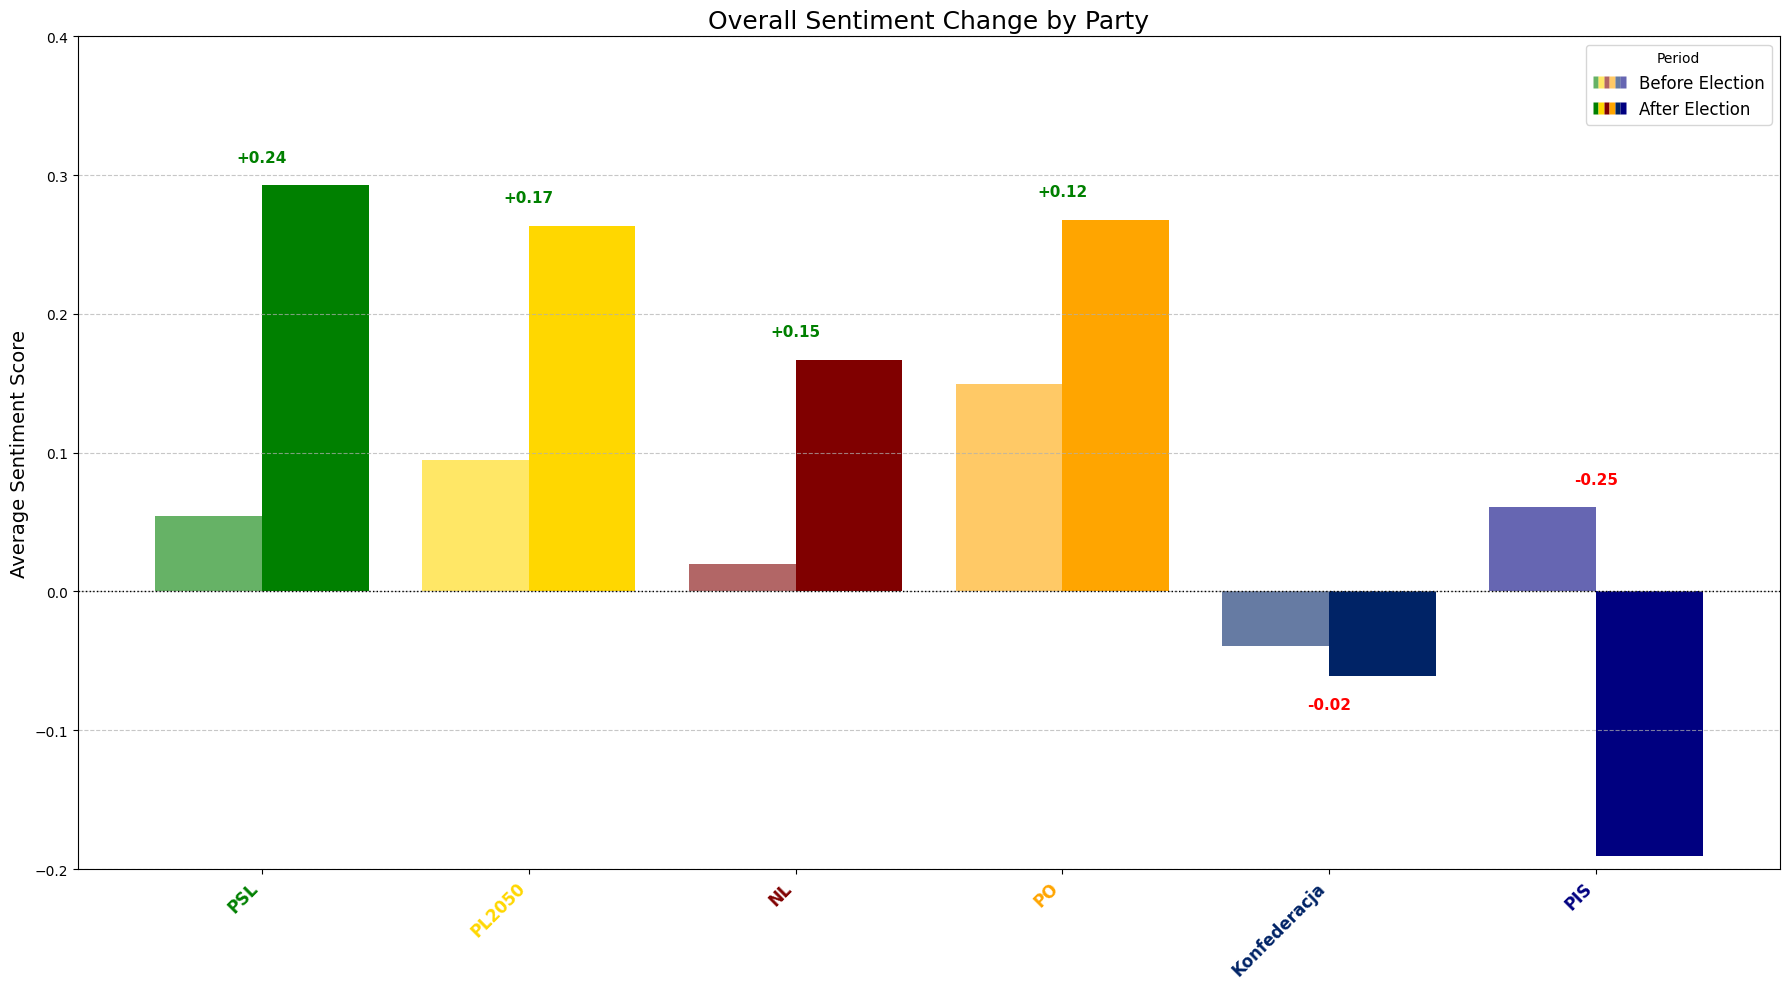


Plot 2: Bar Chart of Absolute Change



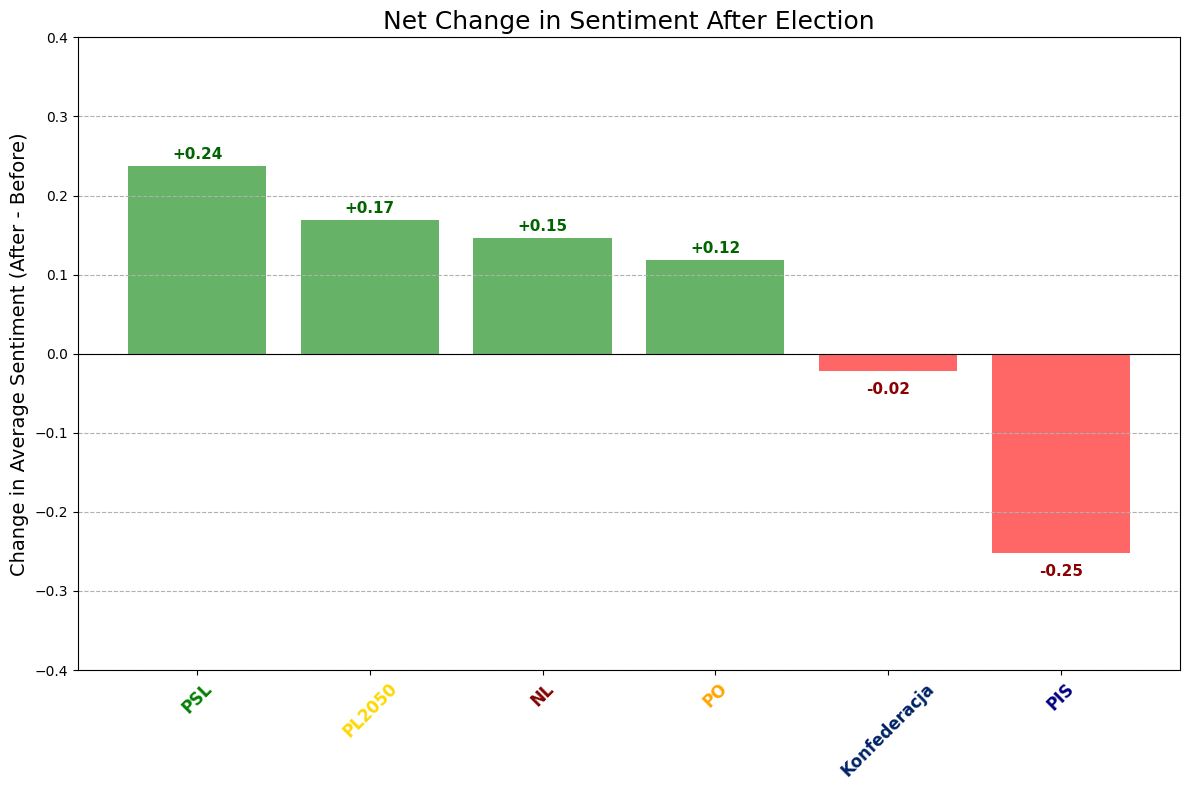


Plot 3: Distribution Analysis

--- Histogram & KDE Plots of Sentiment Score Distribution ---


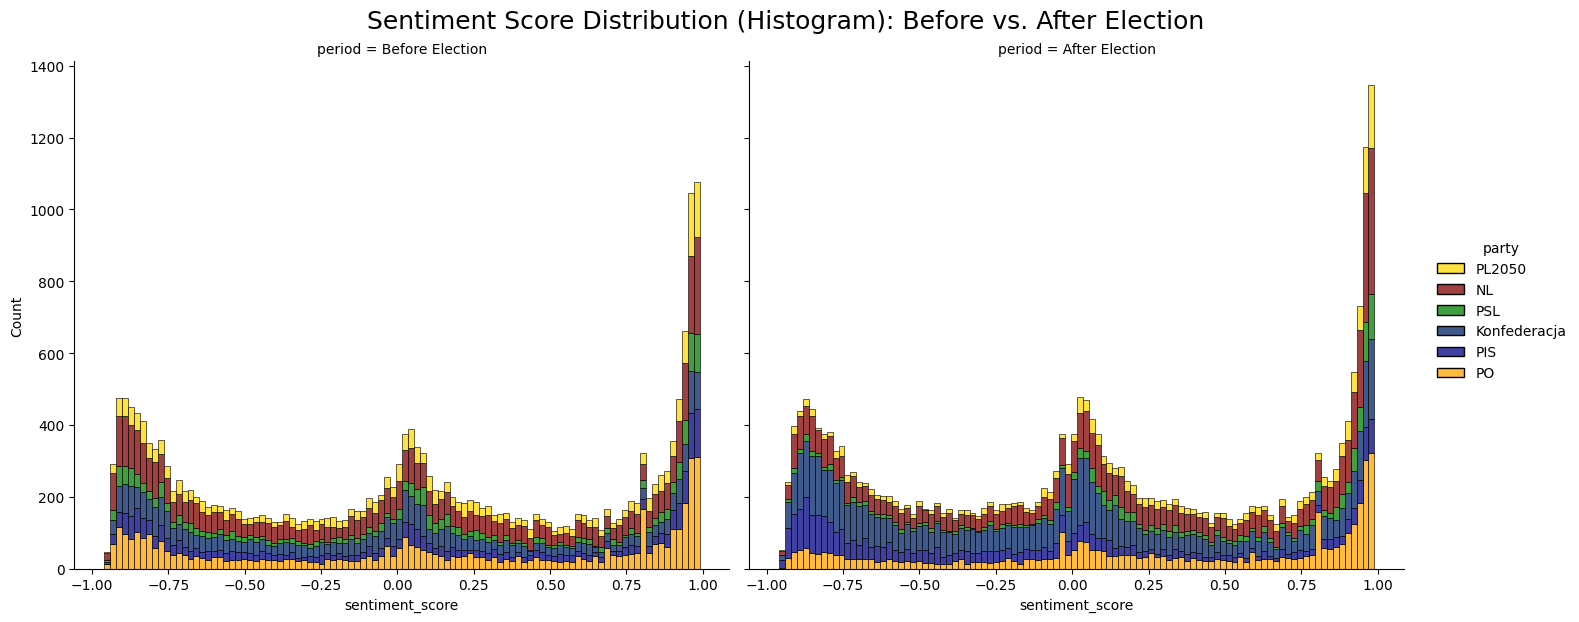

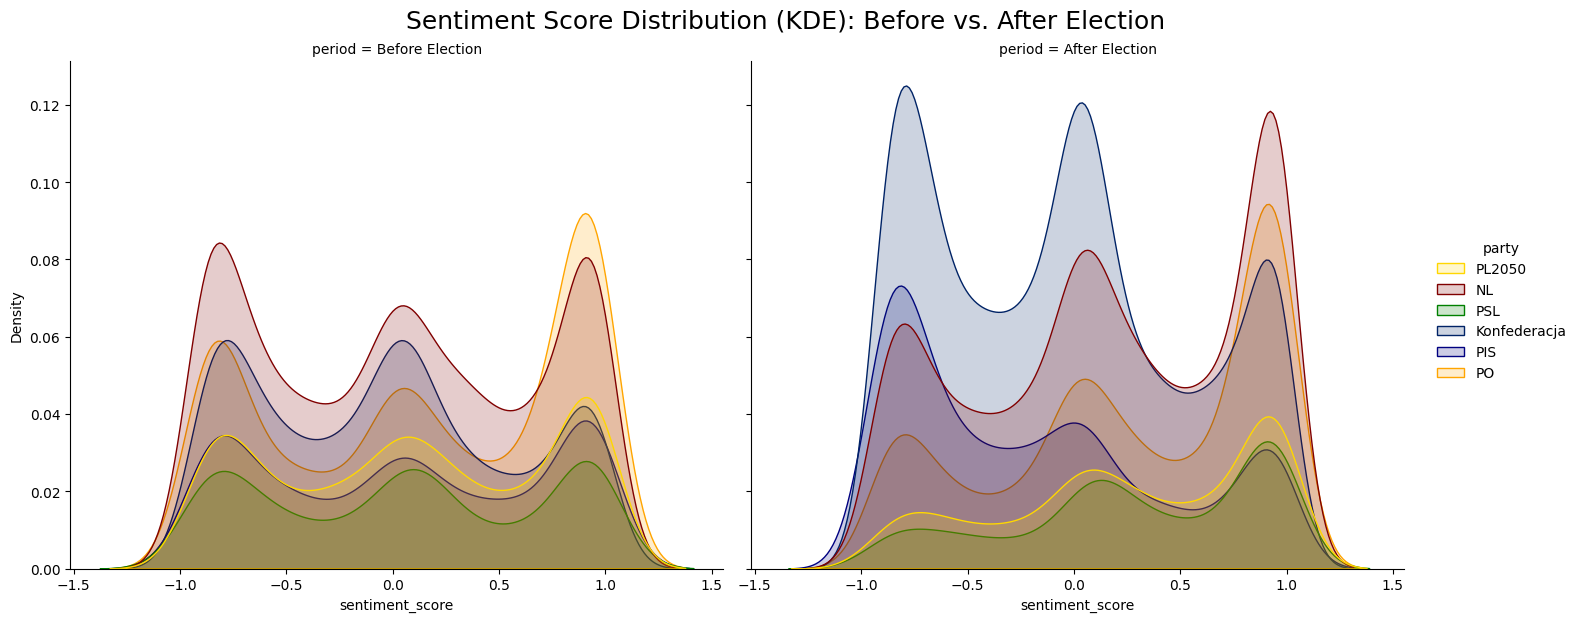


--- Q-Q Plots to Check for Normality ---


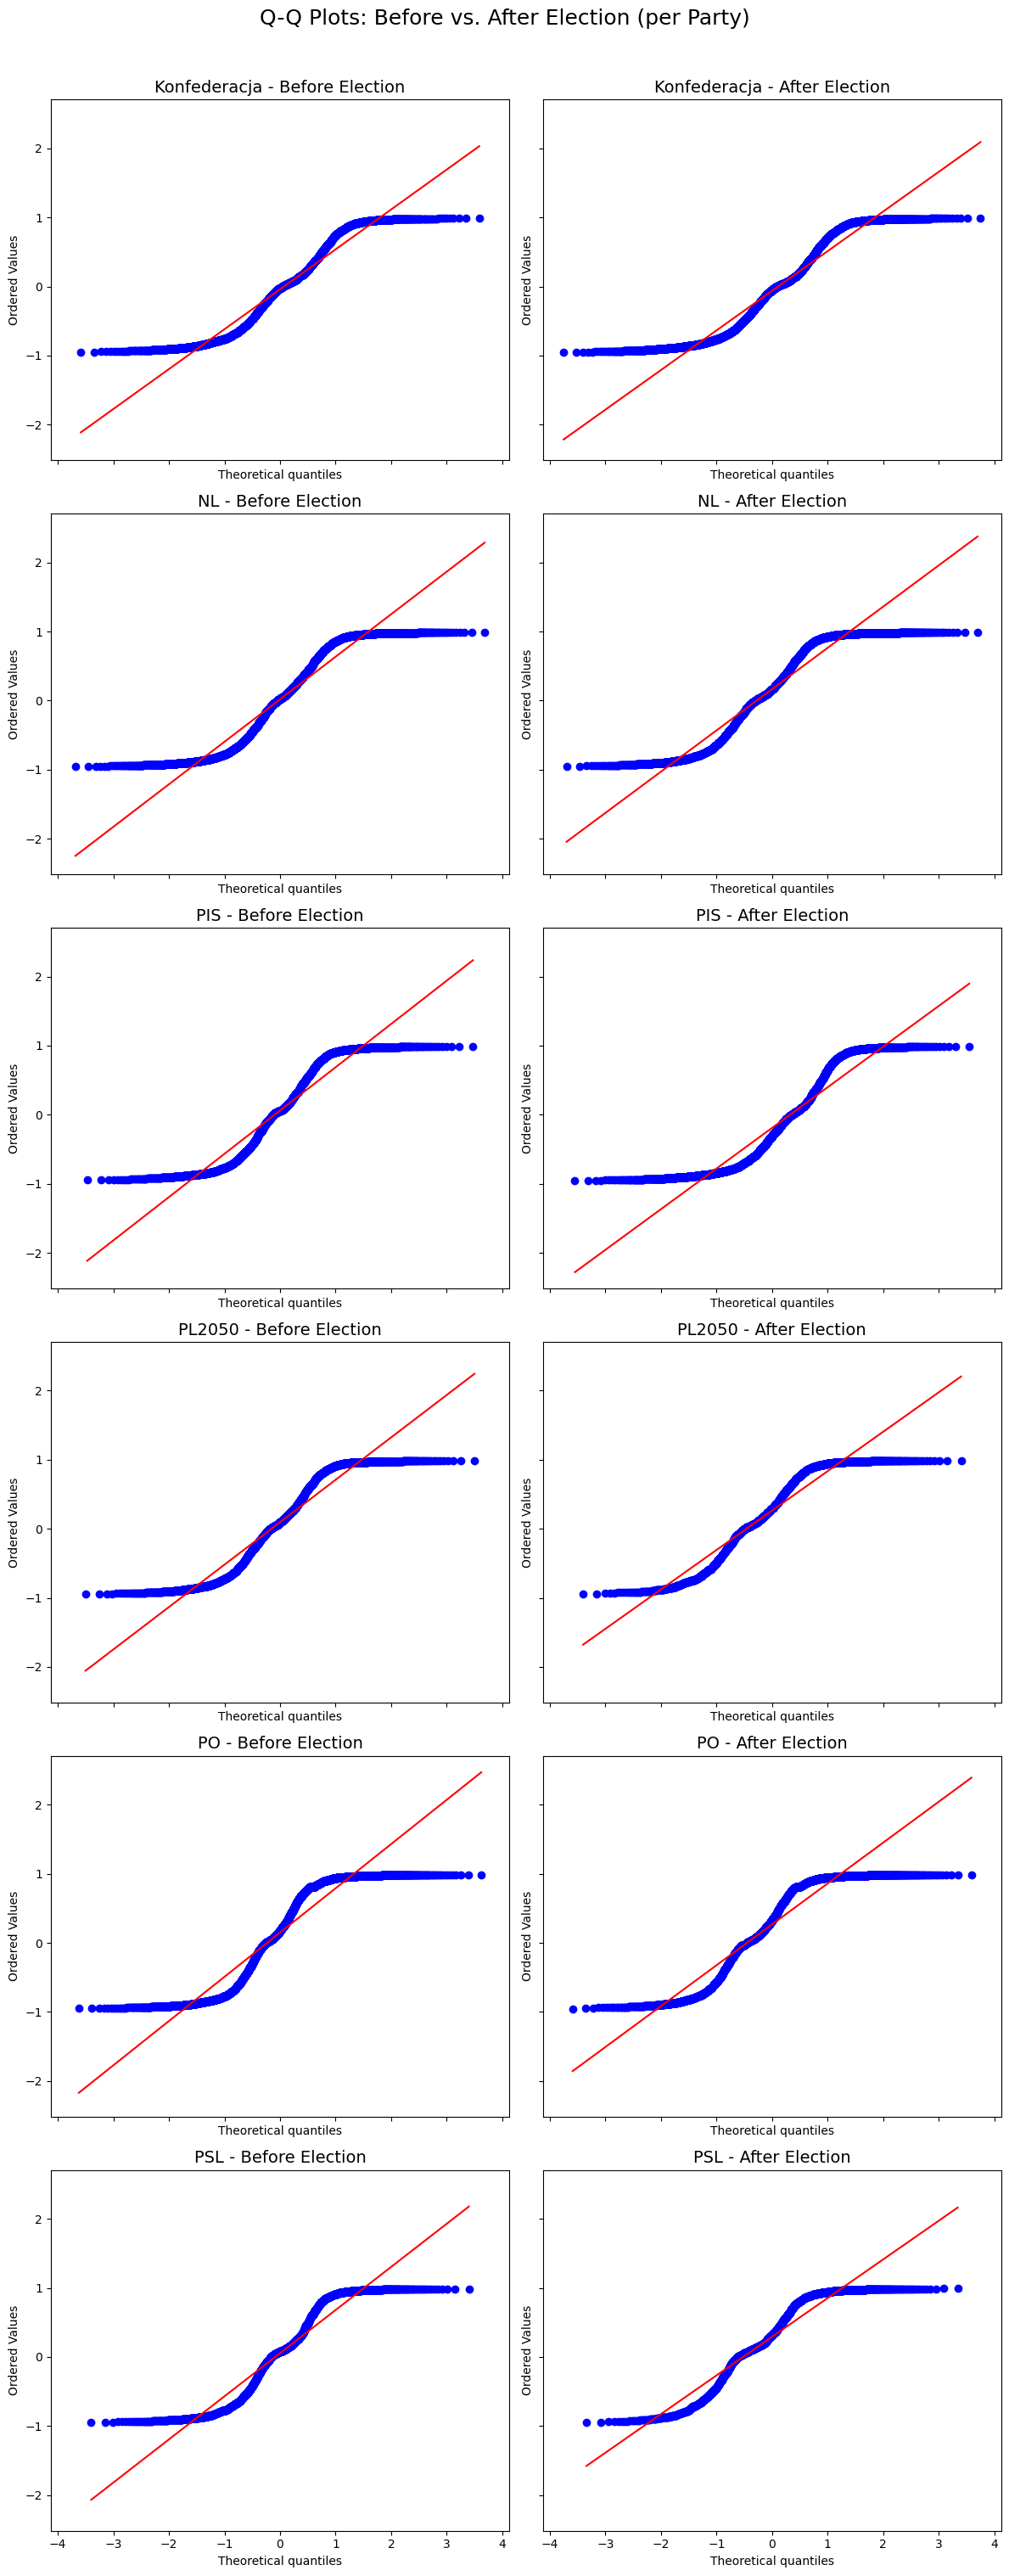

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import stats
from datetime import timedelta
from matplotlib.patches import Patch
from matplotlib.collections import PatchCollection
import os

# --- 0. Setup ---

# Create a directory to save visualizations
output_dir = '../OutputVisualizations'
os.makedirs(output_dir, exist_ok=True)

# Centralized font size configuration for easy adjustment
font_settings = {
    'title': 18,
    'label': 14,
    'tick': 12,
    'legend': 12,
    'annotation': 11
}

party_colors = {
    'Konfederacja': '#002366',  # Dark Blue
    'NL': '#800000',           # Maroon/Burgundy for Nowa Lewica
    'PL2050': 'gold',          # Yellow/Gold for Polska 2050
    'PO': 'orange',          # Orange for Platforma Obywatelska
    'PSL': 'green',          # Green for Polskie Stronnictwo Ludowe
    'PIS': 'navy',           # Navy Blue for Prawo i Sprawiedliwość
    'Unknown_Party': 'grey'
}

# Differentiated colors for better visualization
# party_colors = {
#     'Konfederacja': '#002366',  # Dark Blue (their most consistent color)
#     'NL': '#800000',           # Maroon/Burgundy for Nowa Lewica
#     'PL2050': 'gold',          # Yellow/Gold for Polska 2050
#     'PO': 'orange',          # Orange for Platforma Obywatelska
#     'PSL': 'green',          # Green for Polskie Stronnictwo Ludowe
#     'PIS': 'red',            # Red (prominent accent color for differentiation)
#     'Unknown_Party': 'grey'
# }

# ASSUMPTION: Your DataFrame 'df_for_bert' is loaded.
if 'sentiment_score' not in df_for_bert.columns:
    df_for_bert['sentiment_score'] = df_for_bert['positive_bert'] - df_for_bert['negative_bert']

df_for_bert['created_at'] = pd.to_datetime(df_for_bert['created_at'], utc=True)
election_date = pd.to_datetime('2023-10-15', utc=True)
df_before = df_for_bert[df_for_bert['created_at'] < election_date].copy()
df_after = df_for_bert[df_for_bert['created_at'] >= election_date].copy()

# --- 1. Main Data Calculation (with p-value column) ---
def calculate_overall_sentiment_change(df_b, df_a):
    if df_b.empty or df_a.empty: return None
    senti_before = df_b.groupby('party')['sentiment_score'].agg(['mean', 'count']).rename(columns={'mean': 'sentiment_before', 'count': 'tweets_before'})
    senti_after = df_a.groupby('party')['sentiment_score'].agg(['mean', 'count']).rename(columns={'mean': 'sentiment_after', 'count': 'tweets_after'})
    comparison_df = pd.concat([senti_before, senti_after], axis=1).fillna(0)
    
    comparison_df['change'] = comparison_df['sentiment_after'] - comparison_df['sentiment_before']
    comparison_df['pct_change'] = ((comparison_df['change'] / abs(comparison_df['sentiment_before'])) * 100).replace([np.inf, -np.inf], np.nan)
    
    # Calculate and add the p-value column
    p_values = [stats.mannwhitneyu(df_b[df_b['party'] == p]['sentiment_score'], df_a[df_a['party'] == p]['sentiment_score']).pvalue 
                if not df_b[df_b['party'] == p].empty and not df_a[df_a['party'] == p].empty else np.nan 
                for p in comparison_df.index]
    comparison_df['p_value'] = p_values
    comparison_df['Is Significant (p<0.05)'] = comparison_df['p_value'] < 0.05
    return comparison_df

comparison_table = calculate_overall_sentiment_change(df_before, df_after) if not df_for_bert.empty else None
if comparison_table is not None:
    print("--- Overall Sentiment Change Data ---")
    display(comparison_table)

# --- 2. Visualization Functions ---
class MulticolorPatch(object):
    def __init__(self, colors, alpha=1.0): self.colors = colors; self.alpha = alpha
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height; patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors)*i-handlebox.xdescent, -handlebox.ydescent], width/len(orig_handle.colors), height, facecolor=c, alpha=orig_handle.alpha, edgecolor='none'))
        patch = PatchCollection(patches, match_original=True); handlebox.add_artist(patch); return patch

def plot_main_vertical_bar(df, colors_dict):
    if df is None: return
    print("\n" + "="*80)
    print("Plot 1: Overall Sentiment Change (Vertical Bar Chart)")
    print("="*80 + "\n")
    plot_df = df.sort_values('change', ascending=False)
    parties = plot_df.index; x = np.arange(len(parties)); width = 0.4
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.bar(x - width/2, plot_df['sentiment_before'], width, color=[colors_dict.get(p, 'grey') for p in parties], alpha=0.6)
    ax.bar(x + width/2, plot_df['sentiment_after'], width, color=[colors_dict.get(p, 'grey') for p in parties], alpha=1.0)
    
    for i, party in enumerate(parties):
        change_val = plot_df.loc[party, 'change']
        change_text = f'{change_val:+.2f}'; 
        label_color = 'green' if change_val > 0 else 'red'
        max_height = max(plot_df.loc[party, 'sentiment_before'], plot_df.loc[party, 'sentiment_after'])
        min_height = min(plot_df.loc[party, 'sentiment_before'], plot_df.loc[party, 'sentiment_after'])
        y_pos = max_height + 0.015 if max_height >= 0 else min_height - 0.015
        va = 'bottom' if max_height >= 0 else 'top'
        ax.text(i, y_pos, change_text, ha='center', color=label_color, fontweight='bold', fontsize=font_settings['annotation'], va=va)

    ax.set_ylabel('Average Sentiment Score', fontsize=font_settings['label']); ax.set_title('Overall Sentiment Change by Party', fontsize=font_settings['title'])
    ax.set_xticks(x); ax.set_xticklabels(parties, rotation=45, ha='right', fontsize=font_settings['tick'])
    ax.set_ylim(-0.2, 0.4)
    for tick_label in ax.get_xticklabels():
        tick_label.set_color(colors_dict.get(tick_label.get_text(), 'black')); tick_label.set_fontweight('bold')
    
    legend_color_list = [colors_dict.get(p, 'grey') for p in parties]
    legend_handles = [MulticolorPatch(legend_color_list, alpha=0.6), MulticolorPatch(legend_color_list, alpha=1.0)]
    ax.legend(handles=legend_handles, labels=['Before Election', 'After Election'], handler_map={MulticolorPatch: MulticolorPatchHandler()}, title="Period", fontsize=font_settings['legend'], loc='upper right')
    
    ax.axhline(0, color='black', linewidth=1, linestyle=':'); ax.grid(axis='y', linestyle='--', alpha=0.7); 
    fig.tight_layout()
    plt.savefig(os.path.join(output_dir, 'plot1_vertical_bar_change.png'))
    plt.show()

def plot_absolute_change_chart(df, colors_dict):
    if df is None: return
    print("\n" + "="*80)
    print("Plot 2: Bar Chart of Absolute Change")
    print("="*80 + "\n")
    plot_df = df.sort_values('change', ascending=False).copy()
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(plot_df.index, plot_df['change'], color=['green' if c > 0 else 'red' for c in plot_df['change']], alpha=0.6)
    
    for bar in bars:
        yval = bar.get_height(); label_color = 'darkgreen' if yval > 0 else 'darkred'
        padding = 0.005 if yval > 0 else -0.015
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + padding, f'{yval:+.2f}', va=('bottom' if yval > 0 else 'top'), 
                ha='center', color=label_color, fontweight='bold', fontsize=font_settings['annotation'])
        
    ax.set_ylabel('Change in Average Sentiment (After - Before)', fontsize=font_settings['label']); ax.set_title('Net Change in Sentiment After Election', fontsize=font_settings['title'])
    ax.set_ylim(-0.4, 0.4); ax.tick_params(axis='x', rotation=45, labelsize=font_settings['tick'])
    ax.axhline(0, color='black', linewidth=0.8)
    for tick_label in ax.get_xticklabels():
        tick_label.set_color(colors_dict.get(tick_label.get_text(), 'black')); tick_label.set_fontweight('bold')
    ax.grid(axis='y', linestyle='--'); fig.tight_layout()
    plt.savefig(os.path.join(output_dir, 'plot2_absolute_change.png'))
    plt.show()
    
def plot_distributions(df, colors_dict):
    if df.empty: return
    print("\n" + "="*80)
    print("Plot 3: Distribution Analysis")
    print("="*80 + "\n")
    df['period'] = np.where(df['created_at'] < election_date, 'Before Election', 'After Election')
    
    print("--- Histogram & KDE Plots of Sentiment Score Distribution ---")
    g = sns.displot(data=df, x="sentiment_score", hue="party", col="period", kind="hist", bins=100, multiple="stack", 
                    palette=colors_dict, col_order=['Before Election', 'After Election'], height=6, aspect=1.2)
    g.fig.suptitle('Sentiment Score Distribution (Histogram): Before vs. After Election', y=1.03, fontsize=font_settings['title'])
    plt.savefig(os.path.join(output_dir, 'plot3a_distribution_histogram.png'))
    plt.show()

    g_kde = sns.displot(data=df, x="sentiment_score", hue="party", col="period", kind="kde", palette=colors_dict, 
                        col_order=['Before Election', 'After Election'], fill=True, alpha=0.2, height=6, aspect=1.2)
    g_kde.fig.suptitle('Sentiment Score Distribution (KDE): Before vs. After Election', y=1.03, fontsize=font_settings['title'])
    plt.savefig(os.path.join(output_dir, 'plot3b_distribution_kde.png'))
    plt.show()
    
    print("\n--- Q-Q Plots to Check for Normality ---")
    parties_to_plot = sorted(df['party'].unique())
    fig, axes = plt.subplots(len(parties_to_plot), 2, figsize=(12, 5 * len(parties_to_plot)), sharex=True, sharey=True)
    if len(parties_to_plot) == 1: axes = np.array([axes])
    fig.suptitle('Q-Q Plots: Before vs. After Election (per Party)', fontsize=font_settings['title'], y=1.01)
    for i, party in enumerate(parties_to_plot):
        data_before = df_before[df_before['party'] == party]['sentiment_score'].dropna()
        if not data_before.empty:
            stats.probplot(data_before, dist="norm", plot=axes[i, 0])
            axes[i, 0].set_title(f"{party} - Before Election", fontsize=font_settings['label'])
        data_after = df_after[df_after['party'] == party]['sentiment_score'].dropna()
        if not data_after.empty:
            stats.probplot(data_after, dist="norm", plot=axes[i, 1])
            axes[i, 1].set_title(f"{party} - After Election", fontsize=font_settings['label'])
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'plot3c_qq_plots.png'))
    plt.show()

# --- 3. Execute All Functions ---
if comparison_table is not None:
    plot_main_vertical_bar(comparison_table, party_colors)
    plot_absolute_change_chart(comparison_table, party_colors)
    plot_distributions(df_for_bert, party_colors)
else:
    print("No data to plot.")

Further analysis

To analyze sentiment evolution over time, a 90-day rolling average is applied to the daily sentiment scores for each party. This technique is a standard method in time series analysis for signal processing.

Purpose: Raw daily sentiment data is inherently volatile, subject to sharp fluctuations from daily news cycles, specific events, or viral content. A rolling average acts as a low-pass filter, smoothing out this short-term noise to reveal the more meaningful, underlying long-term trend in a party's communication tone.

Window Selection: A 90-day (approximately one quarter) window was chosen as it provides a robust balance. It is long enough to smooth out weekly and monthly variations but short enough to remain sensitive to major, sustained shifts in communication strategy that occur over several months. This helps in visualizing the trajectory of sentiment leading into and coming out of the election period.

Statistical Significance and Directionality
The core of the analysis relies on rigorous statistical testing to ensure that observed changes are not merely due to random chance.

Choice of Test: Mann-Whitney U Test: This non-parametric test was selected to compare the sentiment distributions from the "before" and "after" periods. This is the correct choice because, as is common with sentiment scores and other real-world behavioral data, the distributions are not normally distributed. Unlike a t-test, the Mann-Whitney U test does not assume normality, making its results more valid and reliable for this type of data. It is also robust to unequal sample sizes between the comparison groups.

Directional Testing: A standard statistical test only indicates if a difference exists. To determine the nature of the change (i.e., an increase or a decrease), the analysis employs one-sided Mann-Whitney U tests. By setting the alternative parameter to 'less' and 'greater', two specific hypotheses are tested for each party and time window:

alternative='less': Tests if the sentiment scores in the "after" period are stochastically greater than the "before" period (a significant increase).

alternative='greater': Tests if the "after" period scores are stochastically less than the "before" period (a significant decrease).

This directional approach provides a more nuanced and complete picture, allowing for the confident classification of each sentiment shift. The results are then aggregated and visualized in the summary heatmap.

=== 0/N ===

To analyze sentiment evolution over time, a 90-day rolling average is applied to the daily sentiment scores for each party. This technique is a standard method in time series analysis for signal processing.

Purpose: Raw daily sentiment data is inherently volatile, subject to sharp fluctuations from daily news cycles, specific events, or viral content. A rolling average acts as a low-pass filter, smoothing out this short-term noise to reveal the more meaningful, underlying long-term trend in a party's communication tone.

Window Selection: A 90-day (approximately one quarter) window was chosen as it provides a robust balance. It is long enough to smooth out weekly and monthly variations but short enough to remain sensitive to major, sustained shifts in communication strategy that occur over several months. This helps in visualizing the trajectory of sentiment leading into and coming out of the election period.

Statistical Significance and Directionality
The core of the analysis relies on rigorous statistical testing to ensure that observed changes are not merely due to random chance.

Directional Testing: A standard statistical test only indicates if a difference exists. To determine the nature of the change (i.e., an increase or a decrease), the analysis employs introduced earlier, one-sided Mann-Whitney U tests. By setting the alternative parameter to 'less' and 'greater', two specific hypotheses are tested for each party and time window:

alternative='less': Tests if the sentiment scores in the "after" period are stochastically greater than the "before" period (a significant increase).

alternative='greater': Tests if the "after" period scores are stochastically less than the "before" period (a significant decrease).

This directional approach provides a more nuanced and complete picture, allowing for the confident classification of each sentiment shift. 

ANALYSIS 1: Granular Sentiment Change Across Different Time Windows
Directional significance tests complete.


,Party,Time Window,Sentiment Before,Sentiment After,Change
0,Konfederacja,1 Week,0.159138,0.346663,0.187525
1,NL,1 Week,0.312110,0.324130,0.012020
2,PIS,1 Week,0.243598,0.050178,-0.193420
3,PL2050,1 Week,0.254968,0.470373,0.215405
4,PO,1 Week,0.332386,0.565643,0.233257



ANALYSIS 2: Time Series Visualizations

--- Generating Combined Sentiment Trend Plot ---


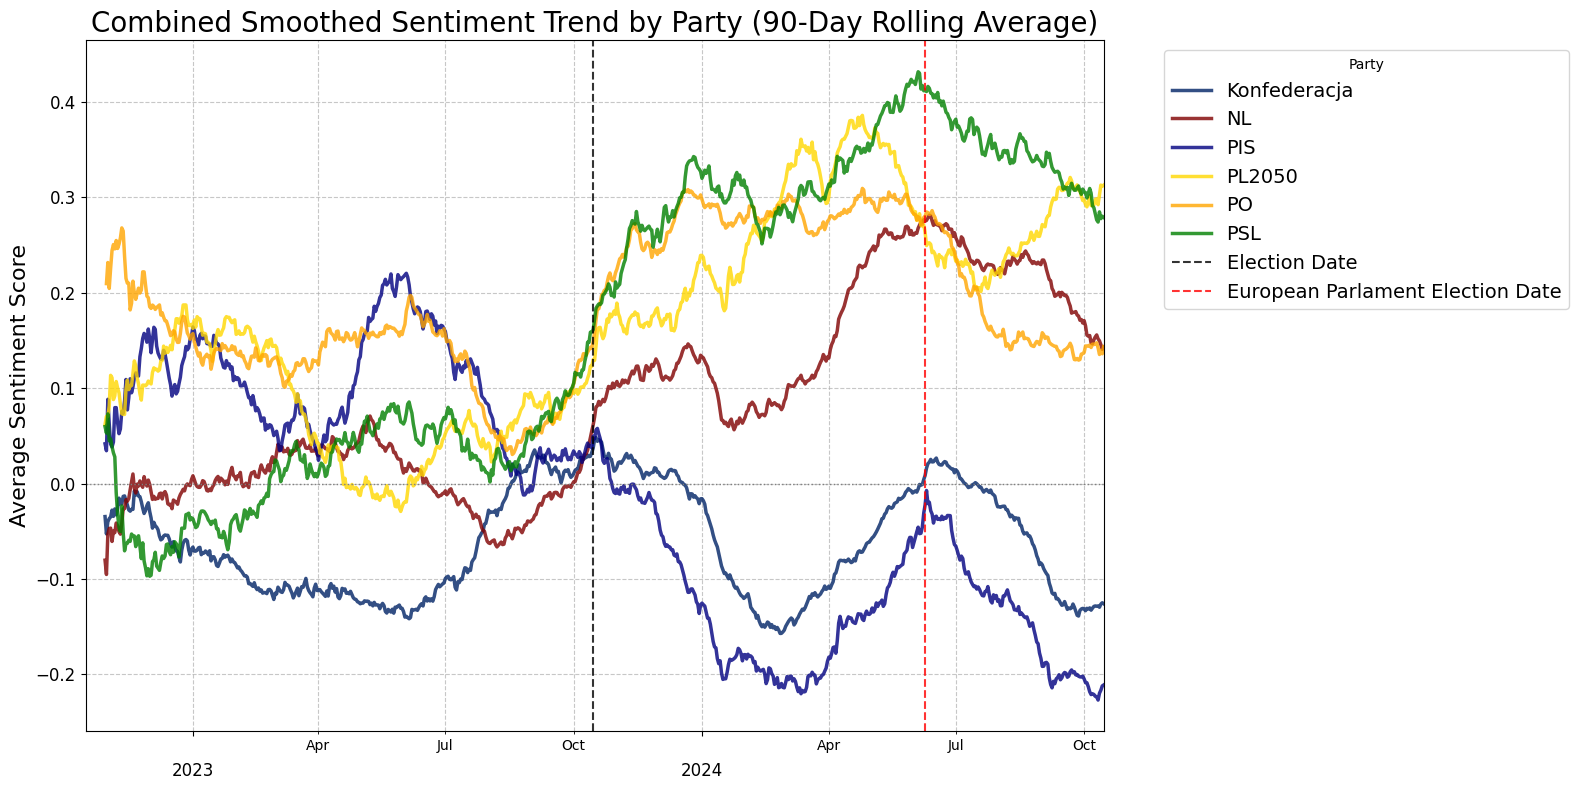


--- Generating Grid of Party Sentiment Trends ---


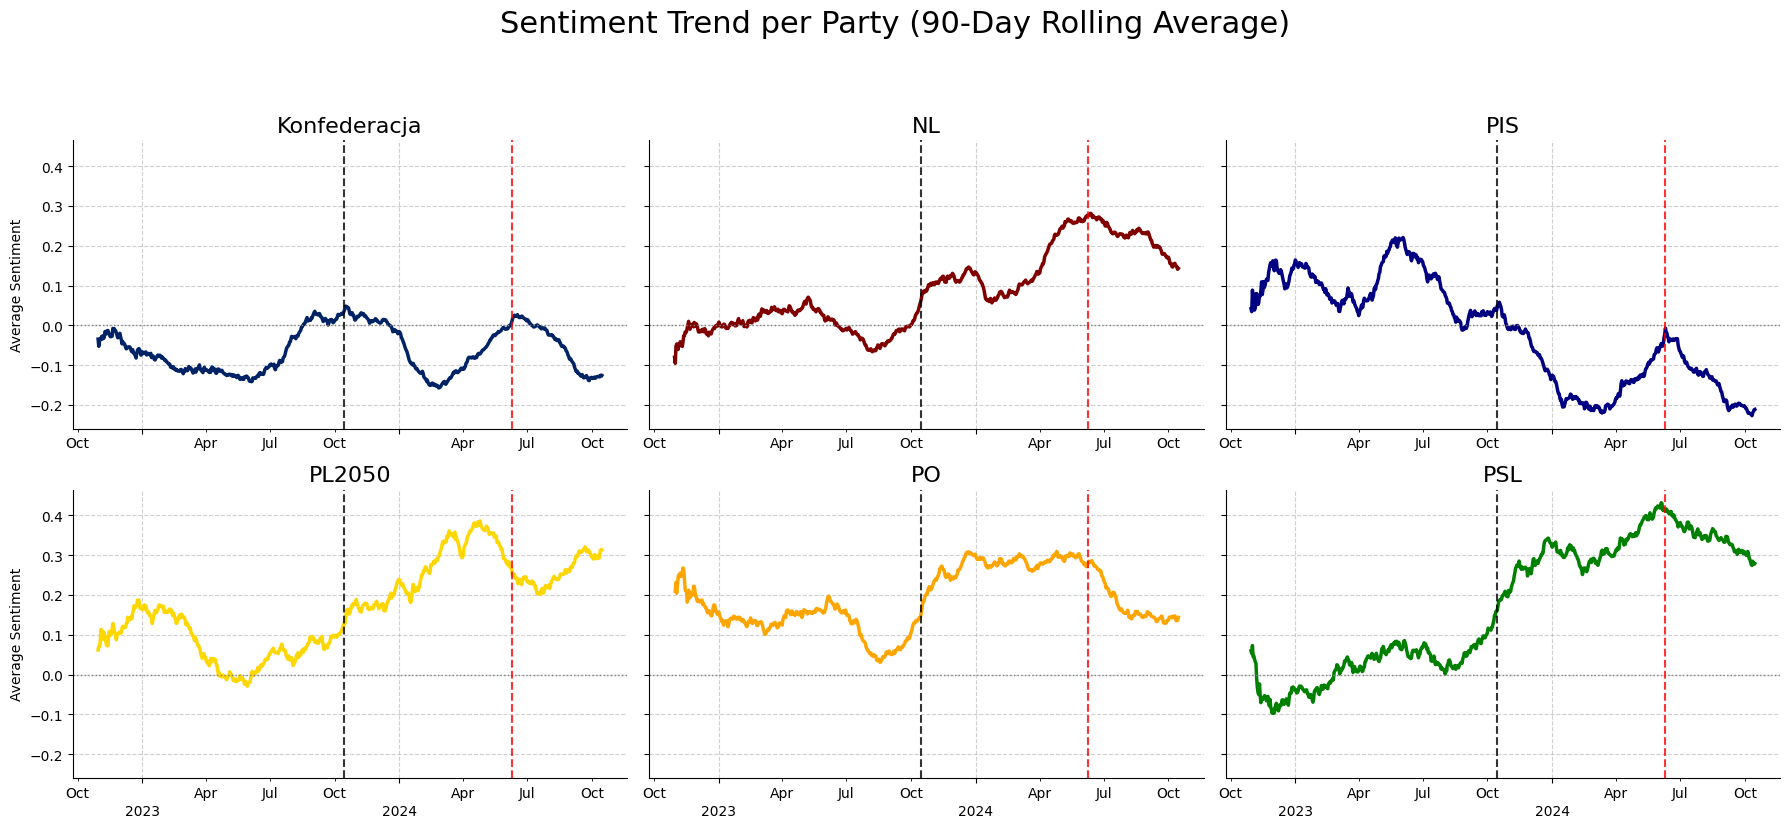


ANALYSIS 3: Significance Analysis Visualizations

--- Generating Heatmap Summary for All Time Windows ---


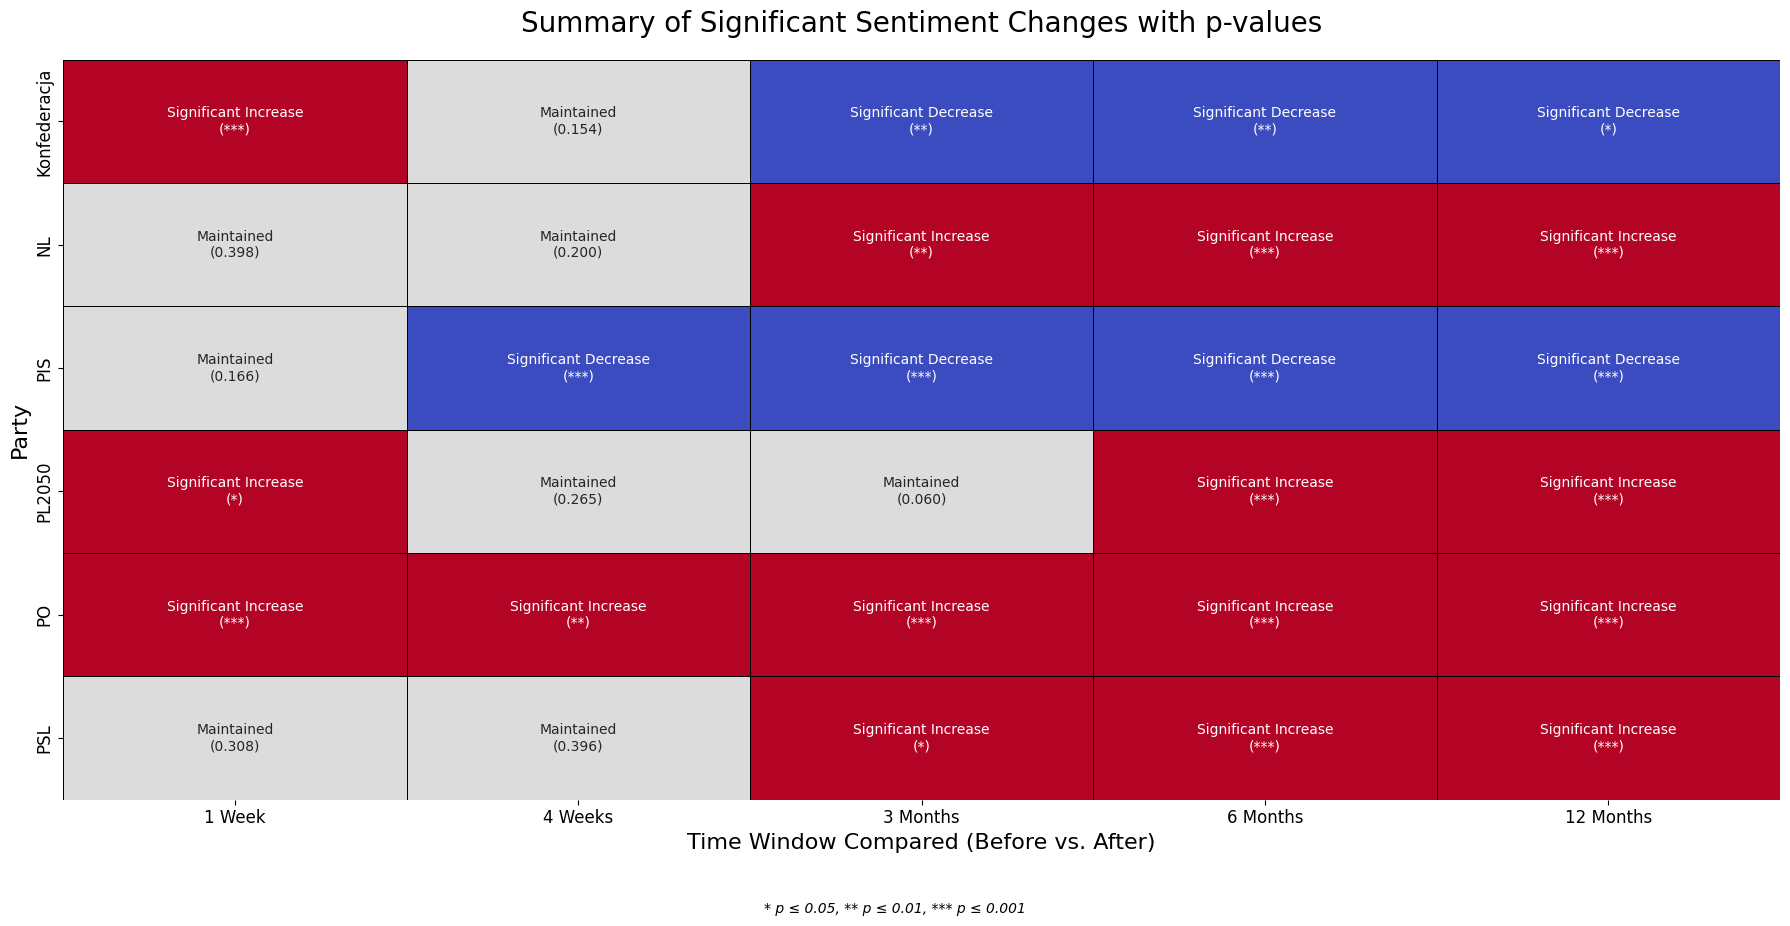


--- Generating Heatmap for 12-Month Window Only ---


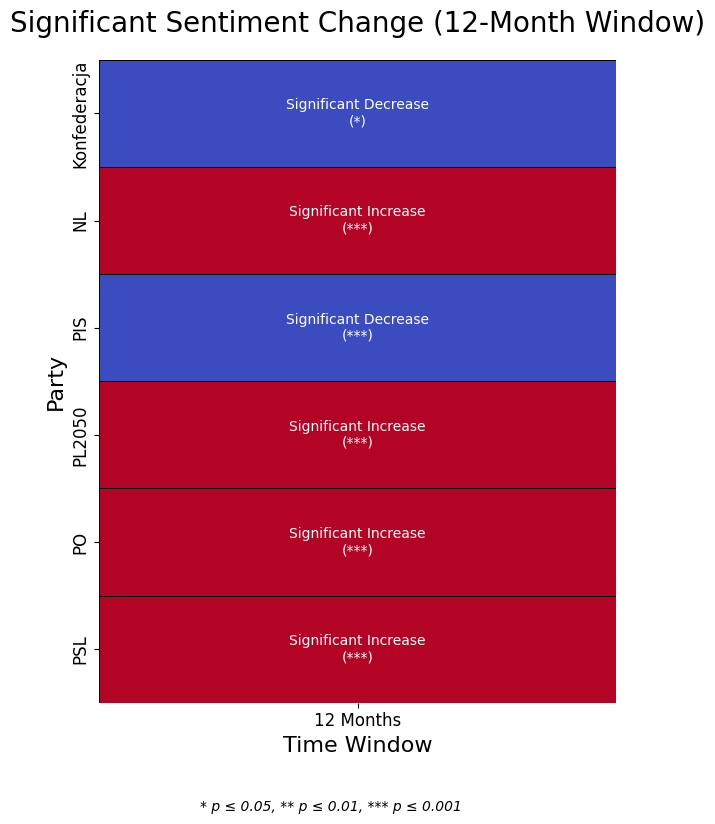


--- Generating Annotated Bar Chart for 12-Month Change ---


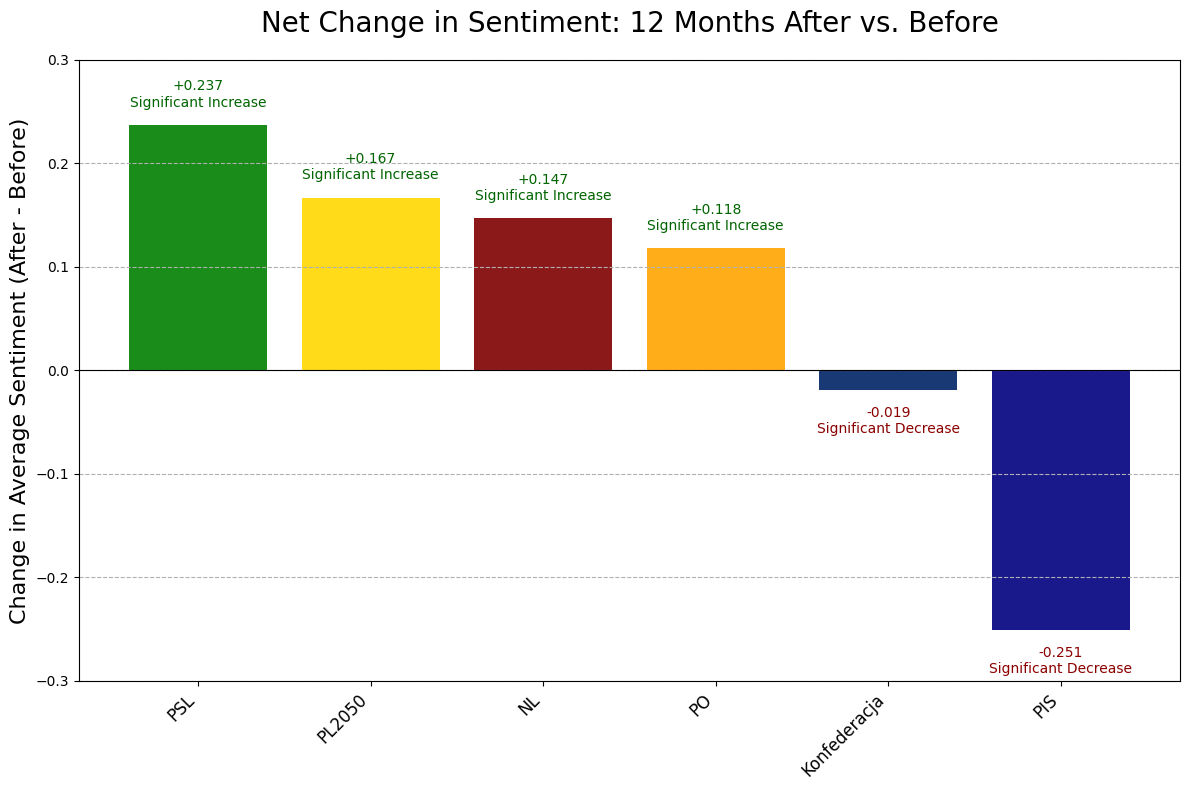


All analyses are complete. Plots have been saved to '../OutputVisualizations/'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from datetime import timedelta, timezone
from IPython.display import display
import os

# --- 0. Setup ---
# Set the output directory to a parent folder
output_dir = '../OutputVisualizations'
os.makedirs(output_dir, exist_ok=True)

# Centralized font size configuration for easy adjustment
font_settings = {
    'title': 20, 'suptitle': 22, 'label': 16,
    'tick': 12, 'legend': 14, 'annotation': 10, 'footnote': 10
}

# Define key dates to mark on time series plots. You can add more here.
# Format: "Event Name": ('YYYY-MM-DD', 'color', 'linestyle')
# Linestyle options: '--' (dashed), '-' (solid), ':' (dotted), '-.' (dashdot)
key_dates = {
    "Election Date": ('2023-10-15', 'black', '--'),
    "European Parlament Election Date": ('2024-06-09', 'red', '--')
}

# The user should define their party_colors dictionary in a previous cell.
# party_colors = {
#     'Konfederacja': '#002366',  # Dark Blue
#     'NL': '#800000',           # Maroon/Burgundy
#     'PL2050': 'gold',          # Yellow/Gold
#     'PO': 'orange',          # Orange
#     'PSL': 'green',          # Green
#     'PIS': 'red',            # Red (differentiated)
#     'Unknown_Party': 'grey'
# }

# ASSUMPTION: Your DataFrame 'df_for_bert' and 'party_colors' dictionary are loaded.
if 'df_for_bert' not in locals() or 'party_colors' not in locals():
    raise NameError("Ensure 'df_for_bert' and 'party_colors' are defined before running this script.")

election_date = pd.to_datetime('2023-10-15', utc=True)
parties = sorted(df_for_bert['party'].unique())

# --- 1. Granular Multi-Interval Sentiment Analysis ---
print("="*80)
print("ANALYSIS 1: Granular Sentiment Change Across Different Time Windows")
print("="*80)
intervals = {'1 Week': 7, '4 Weeks': 28, '3 Months': 91, '6 Months': 182, '12 Months': 365}
all_results = []
directional_test_results = []
for label, days in intervals.items():
    before_start, after_end = election_date - timedelta(days=days), election_date + timedelta(days=days)
    df_b_interval = df_for_bert[(df_for_bert['created_at'] >= before_start) & (df_for_bert['created_at'] < election_date)]
    df_a_interval = df_for_bert[(df_for_bert['created_at'] >= election_date) & (df_for_bert['created_at'] < after_end)]
    for party in parties:
        before_scores, after_scores = df_b_interval[df_b_interval['party'] == party]['sentiment_score'].dropna(), df_a_interval[df_a_interval['party'] == party]['sentiment_score'].dropna()
        if not before_scores.empty and not after_scores.empty:
            mean_before, mean_after = before_scores.mean(), after_scores.mean()
            all_results.append({'Party': party, 'Time Window': label, 'Sentiment Before': mean_before, 'Sentiment After': mean_after, 'Change': mean_after - mean_before})
            p_increase, p_decrease = stats.mannwhitneyu(before_scores, after_scores, alternative='less').pvalue, stats.mannwhitneyu(before_scores, after_scores, alternative='greater').pvalue
            direction = "Maintained"
            if p_increase < 0.05: direction = "Significant Increase"
            elif p_decrease < 0.05: direction = "Significant Decrease"
            directional_test_results.append({'Party': party, 'Time Window': label, 'P-Value (Increase)': p_increase, 'P-Value (Decrease)': p_decrease, 'Significant Direction': direction})
final_comparison_table, directional_stats_df = pd.DataFrame(all_results), pd.DataFrame(directional_test_results)
print("Directional significance tests complete."); display(final_comparison_table.head())

# --- 2. Time Series Visualizations ---
print("\n" + "="*80)
print("ANALYSIS 2: Time Series Visualizations")
print("="*80)

def format_date_axis(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator()); ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10])); ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', which='minor', labelsize=font_settings['tick'] - 2)

def add_event_lines(ax, dates_dict):
    for event, (date, color, style) in dates_dict.items():
        ax.axvline(pd.to_datetime(date, utc=True), color=color, linestyle=style, linewidth=1.5, label=event, alpha=0.8)

print("\n--- Generating Combined Sentiment Trend Plot ---")
fig, ax = plt.subplots(figsize=(16, 8))
for party in parties:
    party_df = df_for_bert[df_for_bert['party'] == party]
    if not party_df.empty:
        party_df.set_index('created_at')['sentiment_score'].resample('D').mean().rolling(window=90, min_periods=15).mean().plot(label=party, color=party_colors.get(party, 'grey'), ax=ax, linewidth=2.5, alpha=0.8)
add_event_lines(ax, key_dates)
ax.axhline(0, color='grey', linewidth=1, linestyle=':'); ax.set_title('Combined Smoothed Sentiment Trend by Party (90-Day Rolling Average)', fontsize=font_settings['title'])
ax.set_xlabel(None); ax.set_ylabel('Average Sentiment Score', fontsize=font_settings['label'])
ax.tick_params(axis='both', labelsize=font_settings['tick']); ax.grid(True, which='both', linestyle='--', alpha=0.7)
format_date_axis(ax); ax.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=font_settings['legend'])
plt.tight_layout(); plt.savefig(os.path.join(output_dir, "sentiment_trend_combined.png")); plt.show()

print("\n--- Generating Grid of Party Sentiment Trends ---")
df_resampled = df_for_bert.groupby('party').resample('D', on='created_at')[['sentiment_score']].mean().reset_index()
df_resampled['rolling_sentiment'] = df_resampled.groupby('party')['sentiment_score'].transform(lambda x: x.rolling(window=90, min_periods=15).mean())
g = sns.FacetGrid(df_resampled, col="party", col_wrap=3, hue="party", palette=party_colors, height=4, aspect=1.5)
g.map(sns.lineplot, "created_at", "rolling_sentiment", lw=2.5)
g.map(plt.axhline, y=0, color='grey', linestyle=':', lw=1)
for ax in g.axes.flat:
    format_date_axis(ax); ax.grid(True, linestyle='--', alpha=0.6); add_event_lines(ax, key_dates)
g.set_titles("{col_name}", size=font_settings['label']); g.set_axis_labels("", "Average Sentiment")
g.fig.suptitle('Sentiment Trend per Party (90-Day Rolling Average)', fontsize=font_settings['suptitle'], y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.savefig(os.path.join(output_dir, "sentiment_trend_grid.png")); plt.show()

# --- 3. Significance Analysis Visualizations ---
print("\n" + "="*80)
print("ANALYSIS 3: Significance Analysis Visualizations")
print("="*80)

if not directional_stats_df.empty:
    def format_annotation(row):
        direction = row['Significant Direction']
        if direction == 'Significant Increase': p_val = row['P-Value (Increase)']
        elif direction == 'Significant Decrease': p_val = row['P-Value (Decrease)']
        else: p_val = min(row['P-Value (Increase)'], row['P-Value (Decrease)'])
        if p_val <= 0.001: p_text = '(***)'
        elif p_val <= 0.01: p_text = '(**)'
        elif p_val <= 0.05: p_text = '(*)'
        else: p_text = f'({p_val:.3f})'
        return f"{direction}\n{p_text}"
    directional_stats_df['heatmap_annotation'] = directional_stats_df.apply(format_annotation, axis=1)
    direction_map = {"Significant Increase": 1, "Maintained": 0, "Significant Decrease": -1}
    
    print("\n--- Generating Heatmap Summary for All Time Windows ---")
    heatmap_data = directional_stats_df.copy(); heatmap_data['direction_code'] = heatmap_data['Significant Direction'].map(direction_map)
    heatmap_pivot = heatmap_data.pivot_table(index='Party', columns='Time Window', values='direction_code')
    annot_pivot_text = heatmap_data.pivot_table(index='Party', columns='Time Window', values='heatmap_annotation', aggfunc='first')
    time_window_order = ['1 Week', '4 Weeks', '3 Months', '6 Months', '12 Months']
    heatmap_pivot = heatmap_pivot.reindex(columns=time_window_order, level=0).reindex(index=parties)
    annot_pivot_text = annot_pivot_text.reindex(columns=time_window_order, level=0).reindex(index=parties)
    plt.figure(figsize=(18, 9)); sns.heatmap(heatmap_pivot, annot=annot_pivot_text, fmt="", cmap="coolwarm", center=0, linewidths=.5, linecolor='black', cbar=False, annot_kws={"size": font_settings['annotation']})
    plt.title('Summary of Significant Sentiment Changes with p-values', fontsize=font_settings['title'], pad=20)
    plt.xlabel('Time Window Compared (Before vs. After)', fontsize=font_settings['label']); plt.ylabel('Party', fontsize=font_settings['label'])
    plt.tick_params(axis='both', labelsize=font_settings['tick'])
    plt.figtext(0.5, -0.02, '* p ≤ 0.05, ** p ≤ 0.01, *** p ≤ 0.001', ha="center", fontsize=font_settings['footnote'], style='italic')
    plt.tight_layout(rect=[0, 0.03, 1, 1]); plt.savefig(os.path.join(output_dir, "heatmap_summary_all_windows_with_pvalues.png")); plt.show()
    
    print("\n--- Generating Heatmap for 12-Month Window Only ---")
    df_12m_sig = directional_stats_df[directional_stats_df['Time Window'] == '12 Months'].copy()
    df_12m_sig['direction_code'] = df_12m_sig['Significant Direction'].map(direction_map) 
    heatmap_pivot_12m = df_12m_sig.pivot_table(index='Party', columns='Time Window', values='direction_code')
    annot_pivot_12m = df_12m_sig.pivot_table(index='Party', columns='Time Window', values='heatmap_annotation', aggfunc='first')
    plt.figure(figsize=(6, 8)); sns.heatmap(heatmap_pivot_12m, annot=annot_pivot_12m, fmt="", cmap="coolwarm", center=0, linewidths=.5, linecolor='black', cbar=False, annot_kws={"size": font_settings['annotation']})
    plt.title('Significant Sentiment Change (12-Month Window)', fontsize=font_settings['title'], pad=20)
    plt.xlabel('Time Window', fontsize=font_settings['label']); plt.ylabel('Party', fontsize=font_settings['label'])
    plt.tick_params(axis='both', labelsize=font_settings['tick'])
    plt.figtext(0.5, -0.02, '* p ≤ 0.05, ** p ≤ 0.01, *** p ≤ 0.001', ha="center", fontsize=font_settings['footnote'], style='italic')
    plt.tight_layout(rect=[0, 0.03, 1, 1]); plt.savefig(os.path.join(output_dir, "heatmap_summary_12_months_with_pvalues.png")); plt.show()

    print("\n--- Generating Annotated Bar Chart for 12-Month Change ---")
    df_12m_full = final_comparison_table[final_comparison_table['Time Window'] == '12 Months'].set_index('Party')
    df_12m_sig_info = directional_stats_df[directional_stats_df['Time Window'] == '12 Months'].set_index('Party')
    df_12m_full = df_12m_full.join(df_12m_sig_info.drop('Time Window', axis=1))
    if not df_12m_full.empty:
        df_sorted = df_12m_full.sort_values('Change', ascending=False)
        plt.figure(figsize=(12, 8)); bar_colors = [party_colors.get(p, 'grey') for p in df_sorted.index]
        bars = plt.bar(df_sorted.index, df_sorted['Change'], color=bar_colors, alpha=0.9)
        plt.axhline(0, color='black', linewidth=0.8); plt.ylabel('Change in Average Sentiment (After - Before)', fontsize=font_settings['label'])
        plt.title('Net Change in Sentiment: 12 Months After vs. Before', fontsize=font_settings['title'], pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=font_settings['tick']); plt.ylim(-0.3, 0.3)
        for i, party in enumerate(df_sorted.index):
            row = df_sorted.loc[party]; y_val = row['Change']; label_text = f"{y_val:+.3f}"
            if row['Significant Direction'] != 'Maintained': label_text += f"\n{row['Significant Direction']}"
            text_color = 'darkgreen' if y_val > 0 else 'darkred'; vertical_offset = y_val + (0.015 if y_val > 0 else -0.015)
            plt.text(i, vertical_offset, label_text, ha='center', va='bottom' if y_val > 0 else 'top', fontsize=font_settings['annotation'], color=text_color, bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'))
        plt.grid(axis='y', linestyle='--'); plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "annotated_barchart_12_month_change.png")); plt.show()
else:
    print("Significance tables not generated, skipping visualizations.")

print("\n" + "="*80); print(f"All analyses are complete. Plots have been saved to '{output_dir}/'"); print("="*80)

**Methodology of the Analysis**

**1. Time Series Analysis and Signal Smoothing**
To analyze the evolution of sentiment over time, a 90-day rolling average was applied to the daily mean sentiment scores for each political party. 
This technique is a standard method of signal smoothing used in time series analysis to reduce noise and reveal underlying patterns.

Purpose: Raw daily sentiment data is inherently volatile, subject to sharp fluctuations from daily news cycles, specific events, or viral content. A rolling average acts as a low-pass filter, smoothing this short-term noise to reveal the more meaningful, underlying long-term trend in a party's communication tone. This makes it possible to distinguish sustained strategic shifts from ephemeral reactions.

Window Selection: A 90-day window was chosen as it provides an effective balance. It is long enough to mitigate the effects of weekly and monthly variations but short enough to remain sensitive to major, sustained shifts in communication strategy that occur over several months. This is crucial for visualizing the trajectory of sentiment leading into and following the election period.

**2. Statistical Significance and Directionality Testing**
The core of the analysis relies on statistical testing to ensure that observed changes are not the result of random chance.

**Choice of Test:** 

Mann-Whitney U Test: To compare the sentiment distributions from the periods before and after the election, the Mann-Whitney U test was selected. This non-parametric test is the correct choice for this application for few reasons:

It does not assume a normal distribution. As in Our sentiment scores, the distributions do not follow a Gaussian curve. The Mann-Whitney U test is valid for non-normal data, making its results more reliable than parametric tests like the t-test.

It is robust to imbalanced sample sizes. The number of posts before and after the election per party is not equal. The test effectively handles this imbalance by comparing the rank ordering of the data, not just the means, which prevents distortion from unequal group sizes.

Directional Testing for Analysis. A standard (two-sided) statistical test only indicates if a difference exists. To determine the nature of the change (i.e., an increase or a decrease), the analysis employs one-sided Mann-Whitney U tests. By setting the alternative parameter to 'less' and 'greater', two specific hypotheses are tested for each party across various time windows (e.g., 1 week, 4 weeks, 3 months, 6 months, 12 months):

alternative='less': Tests if the distribution of sentiment scores in the "after" period is stochastically greater than the "before" period, indicating a significant increase.

alternative='greater': Tests if the "after" period scores are stochastically less than the "before" period, indicating a significant decrease.

This directional approach provides much more complete picture, allowing for the classification of each sentiment shift. 

### 4.9. Virality Analysis

Early analyses

## 5. Conclusions

1. The RoBERTa model is able to identify more sophisticated negative tweets compared to VADER. While VADER often predicts that the most negative tweets are single negative words, RoBERTa captures the nuanced meaning of the tweets. There is no need to filter out short tweets with only one word (e.g., "NO") as was necessary with VADER. These tweets are mostly critical of the actions of other parties, with the majority coming from PIS.

2. The most positive tweets identified by the RoBERTa model are more meaningful than those from the VADER method. They are notably longer and often reflect the authors' happiness following certain events, such as meetings with voters or positive election results.

3. According to the VADER analysis, the top 5 politicians with the highest 90th percentile of negative sentiment in their tweets include 2 individuals from NL and 1 from PO, PiS and Konfederacja. In contrast, the RoBERTa model also includes 2 politicians from NL and PO and 1 from PiS. This indicates a difference in predictions made by the VADER and BERT models. 

4. The 90th percentile Positive Sentiment scores are quite comparable among the top 5 politicians. However, there are significant changes when comparing the VADER method to the RoBERTa model. Only one politician stay the same. This discrepancy may be due to the similarity of scores, which can lead to shifts in ranking, especially among closely positioned candidates.

5. The party rankings for negative sentiment are similar between the VADER and RoBERTa methods.

6. The party rankings for average positive sentiment are also very similar between VADER and RoBERTa. The top two parties remain the same in both methods, while the parties ranked third and fourth, as well as fifth and sixth, switch places. 

7. RoBERTa model is harder to interpret because it does not assign pure weights to each word as VADER does. However, it can better detect the most positive and negative tweets, making them more meaningful and truly expressive of positive or negative emotions.

## 6. Refrences

[1] Hutto, C., & Gilbert, E. (2014). VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text. Proceedings of the International AAAI Conference on Web and Social Media, 8(1), 216–225. https://doi.org/10.1609/icwsm.v8i1.14550

[2] Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, and Veselin Stoyanov. 2019. Roberta: A robustly optimized bert pretraining approach. arXiv preprint arXiv:190711692.
